In [1]:
import numpy.random as npr

import jax
import jax.numpy as jnp 
import jax.random as jrnd
from jaxutils import Dataset

import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
# Imports from our code base
from active_search import get_next_y, get_next_candidate_baseline, get_next_candidate, compute_distances
from plotting import plot_candidate, plot_eig
from gp_model import update_model
from search_no_gpjax import generate_true_function, sample_from_posterior

/Users/dicai/miniconda3/envs/apm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Set up the problem

In [3]:
seed = 2 # seed to use for all expts
num_iters = 14 # number of iterations to run
knot_N = 40 # number of points to discretize space into

# grid to discretize design space into
knot_x = jnp.linspace(0, 1, knot_N)
design_space = knot_x[:, jnp.newaxis]

npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# generate true data and envelope
true_y, true_envelope = generate_true_function(design_space, knot_N)

# Baseline: no convex hull information

Iteration:  0
CPU times: user 1.01 s, sys: 10.5 ms, total: 1.02 s
Wall time: 1.03 s
Iteration:  1
CPU times: user 788 ms, sys: 7.04 ms, total: 795 ms
Wall time: 792 ms
Iteration:  2
CPU times: user 819 ms, sys: 6.72 ms, total: 826 ms
Wall time: 823 ms
Iteration:  3
CPU times: user 761 ms, sys: 6.53 ms, total: 767 ms
Wall time: 764 ms
Iteration:  4
CPU times: user 763 ms, sys: 8.44 ms, total: 771 ms
Wall time: 768 ms
Iteration:  5
CPU times: user 728 ms, sys: 6.23 ms, total: 734 ms
Wall time: 731 ms
Iteration:  6
CPU times: user 718 ms, sys: 6.87 ms, total: 725 ms
Wall time: 722 ms
Iteration:  7
CPU times: user 704 ms, sys: 7.99 ms, total: 712 ms
Wall time: 709 ms
Iteration:  8
CPU times: user 734 ms, sys: 6.94 ms, total: 741 ms
Wall time: 737 ms
Iteration:  9
CPU times: user 674 ms, sys: 7.78 ms, total: 682 ms
Wall time: 679 ms
Iteration:  10
CPU times: user 648 ms, sys: 6.26 ms, total: 654 ms
Wall time: 651 ms
Iteration:  11
CPU times: user 651 ms, sys: 8.64 ms, total: 659 ms
Wall tim

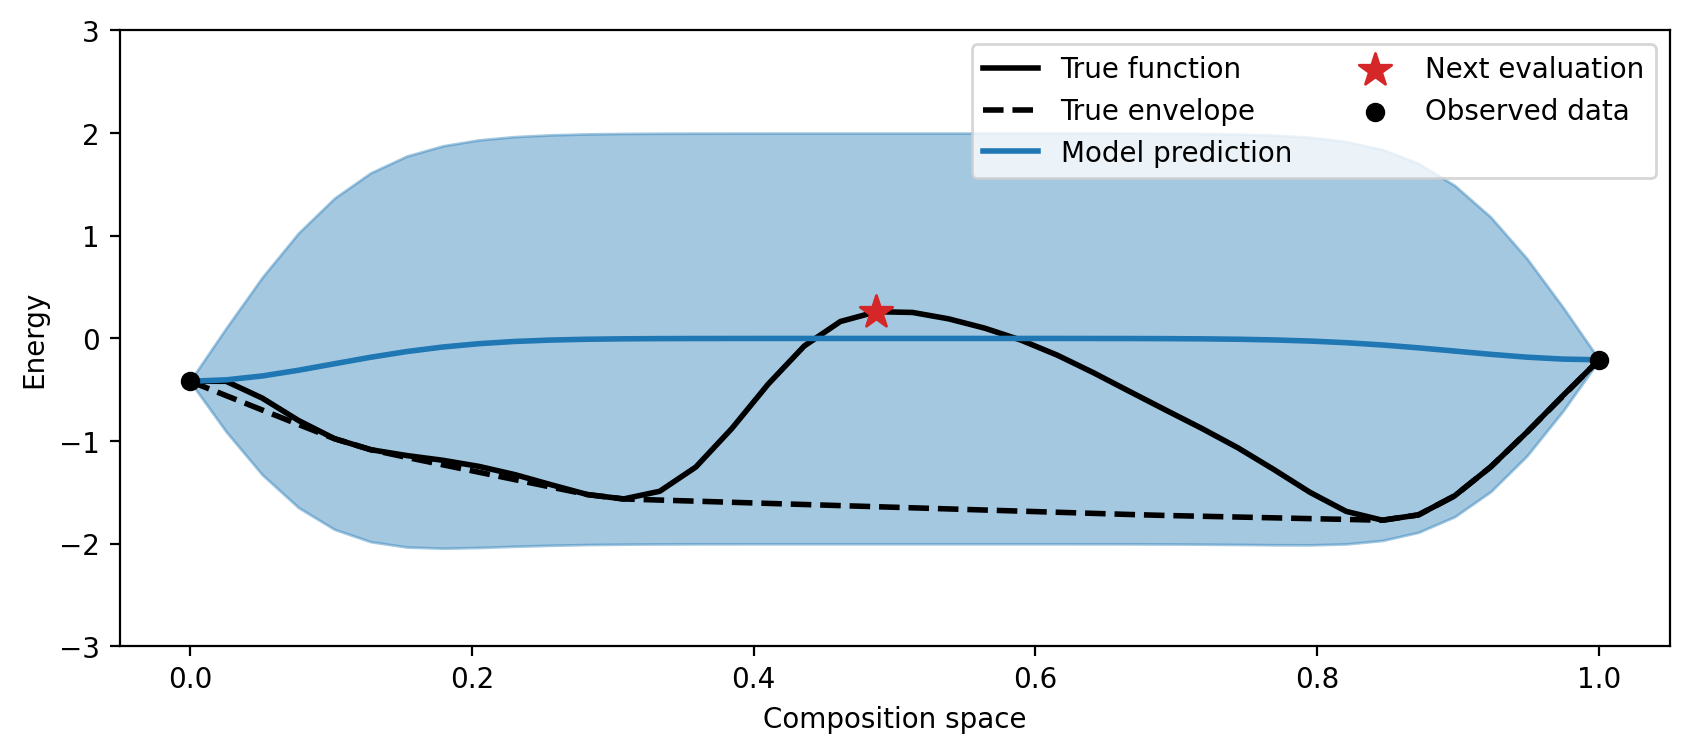

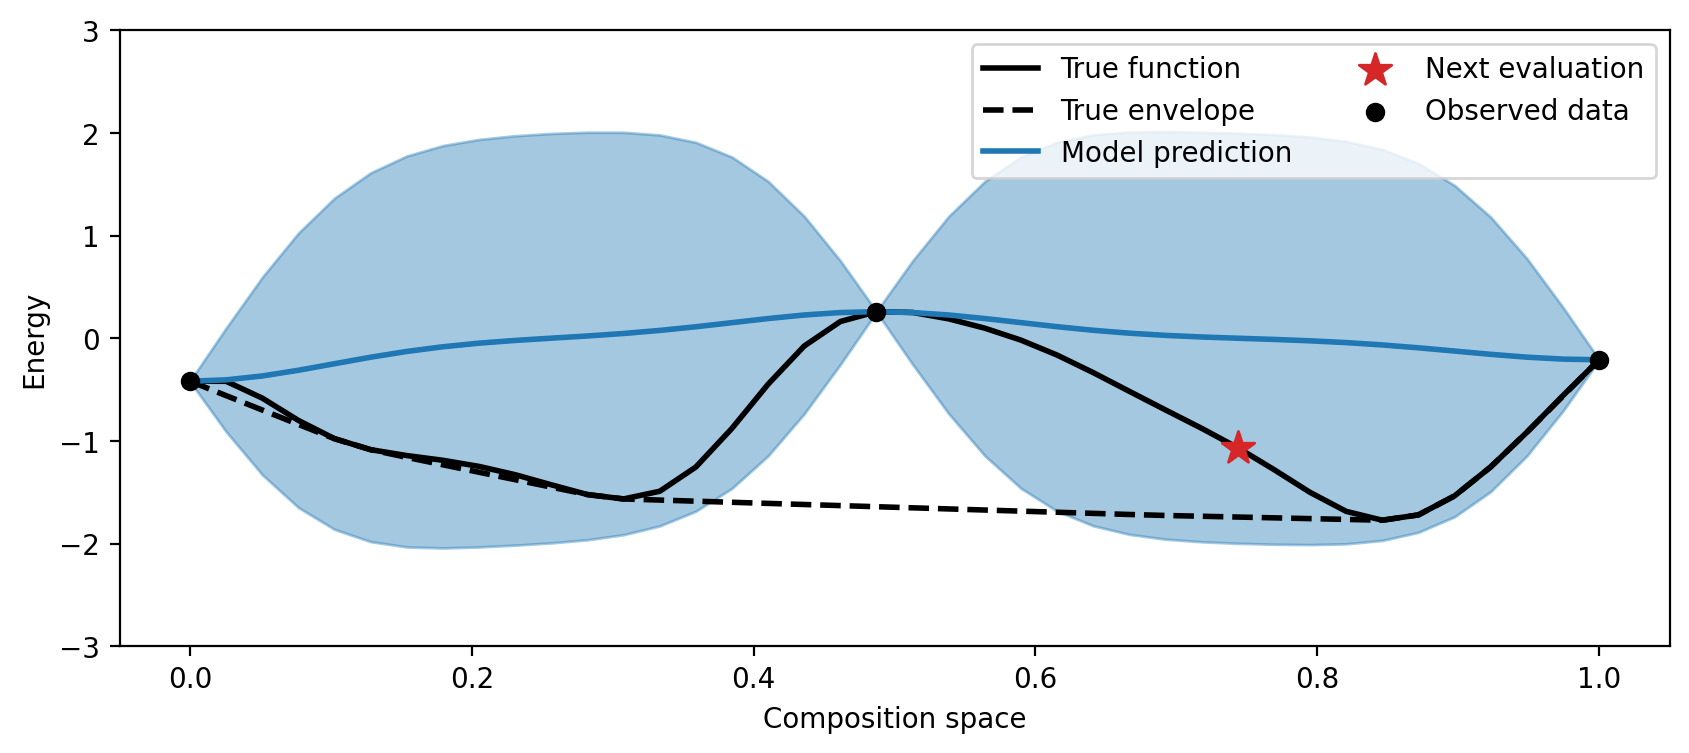

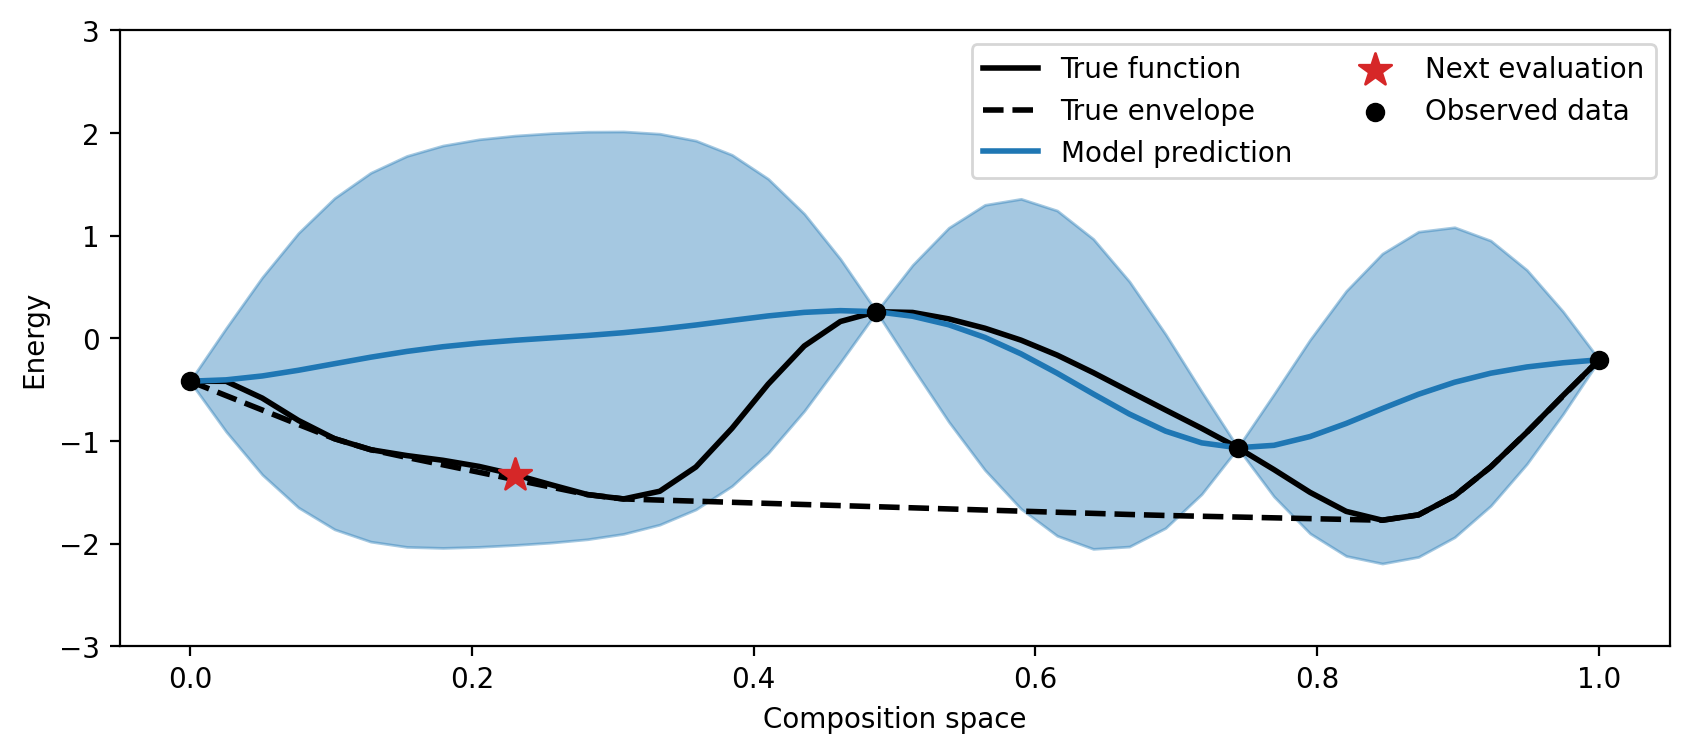

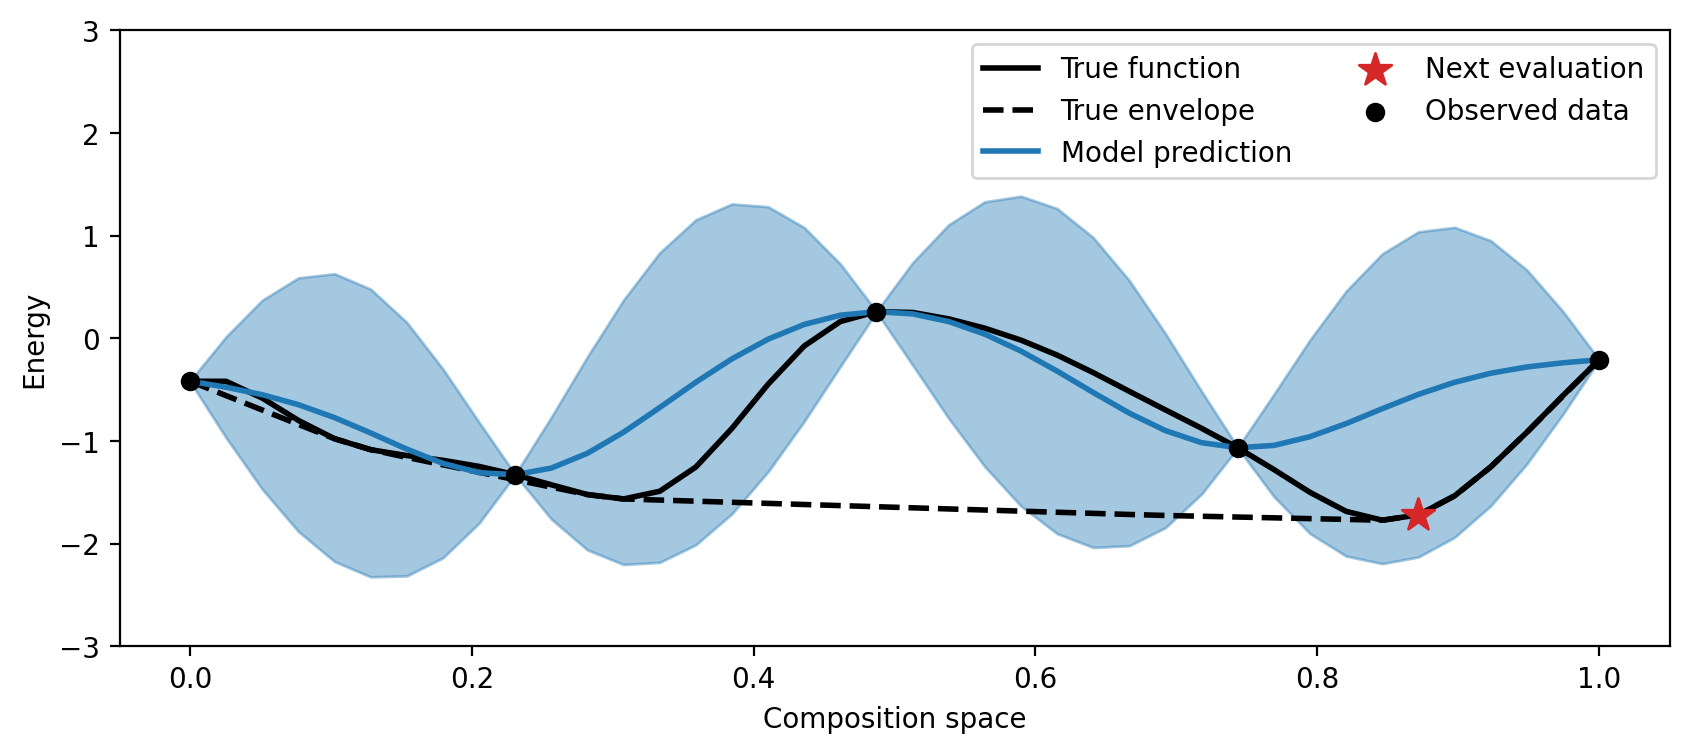

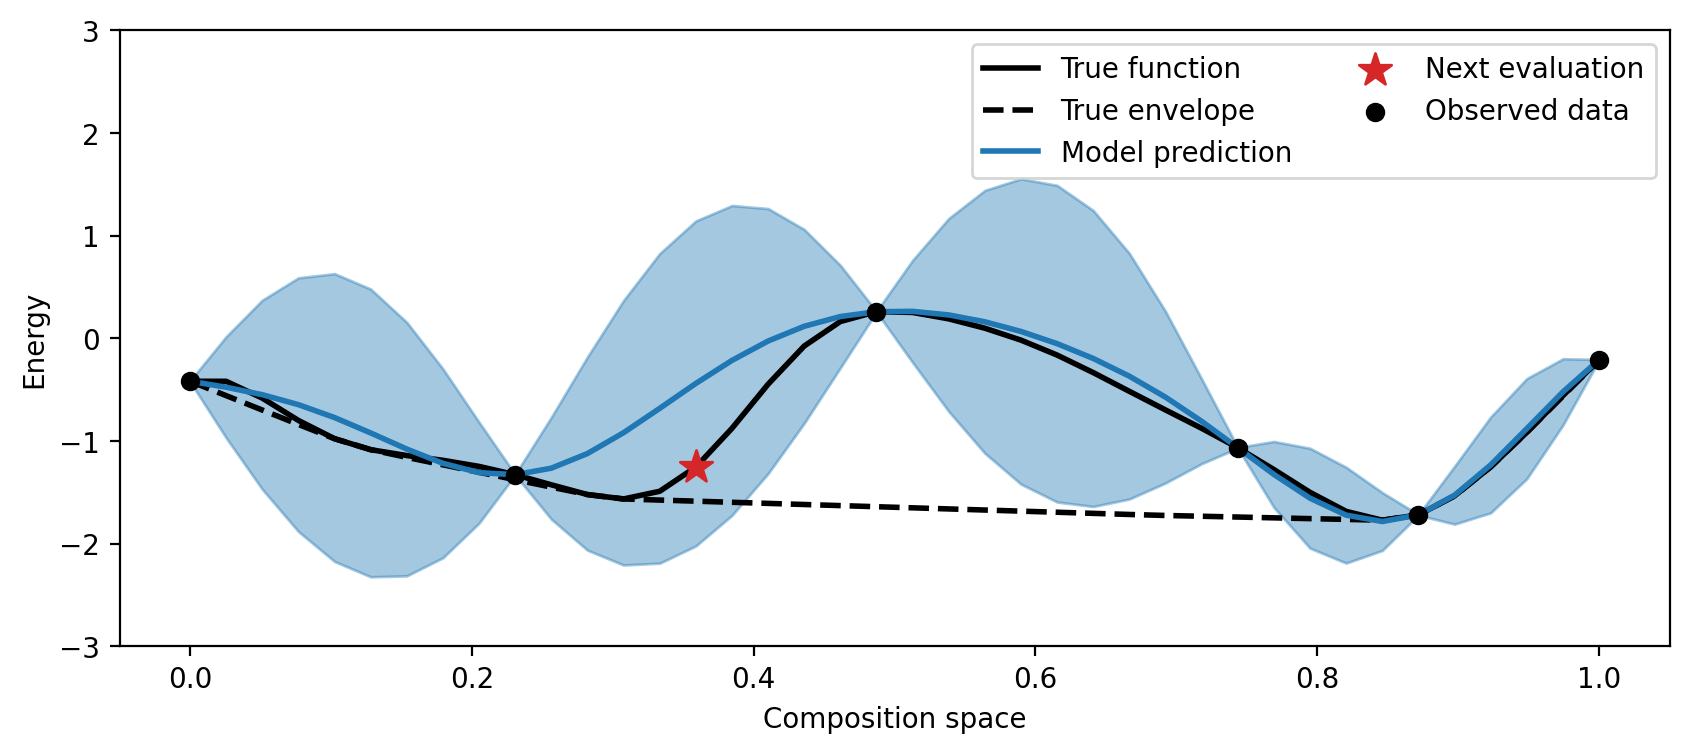

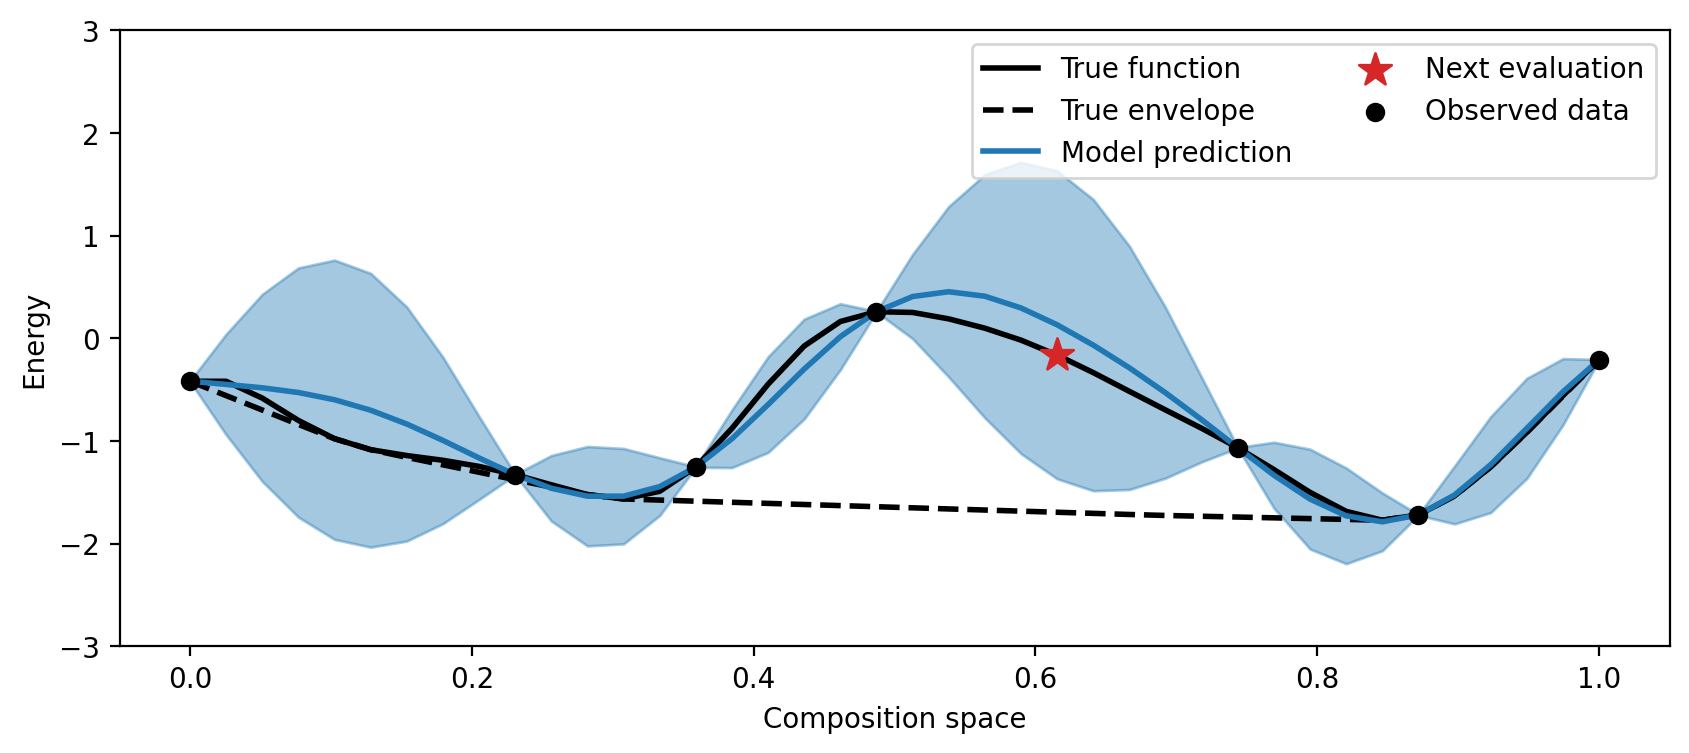

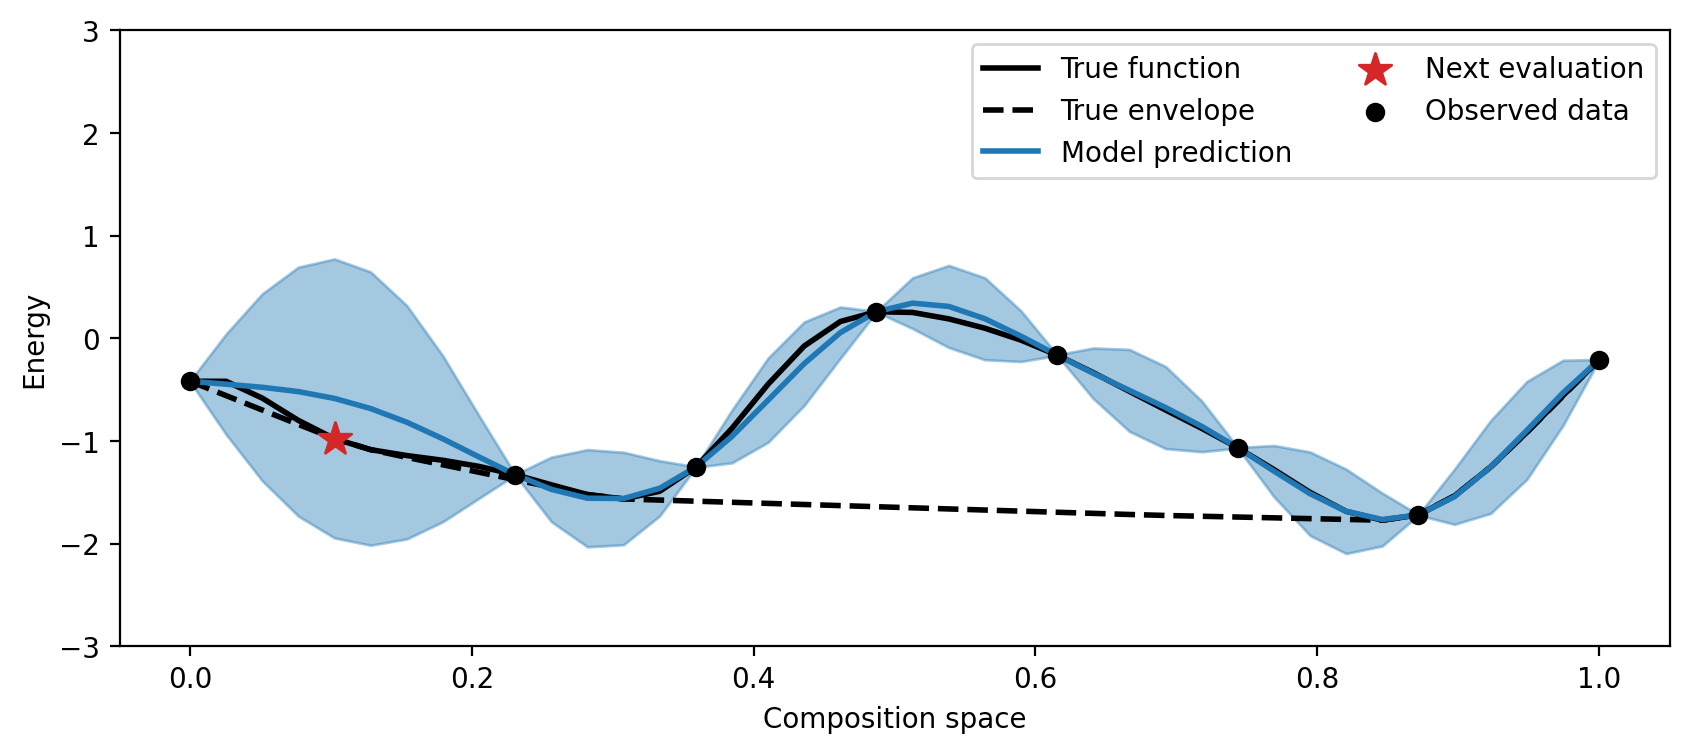

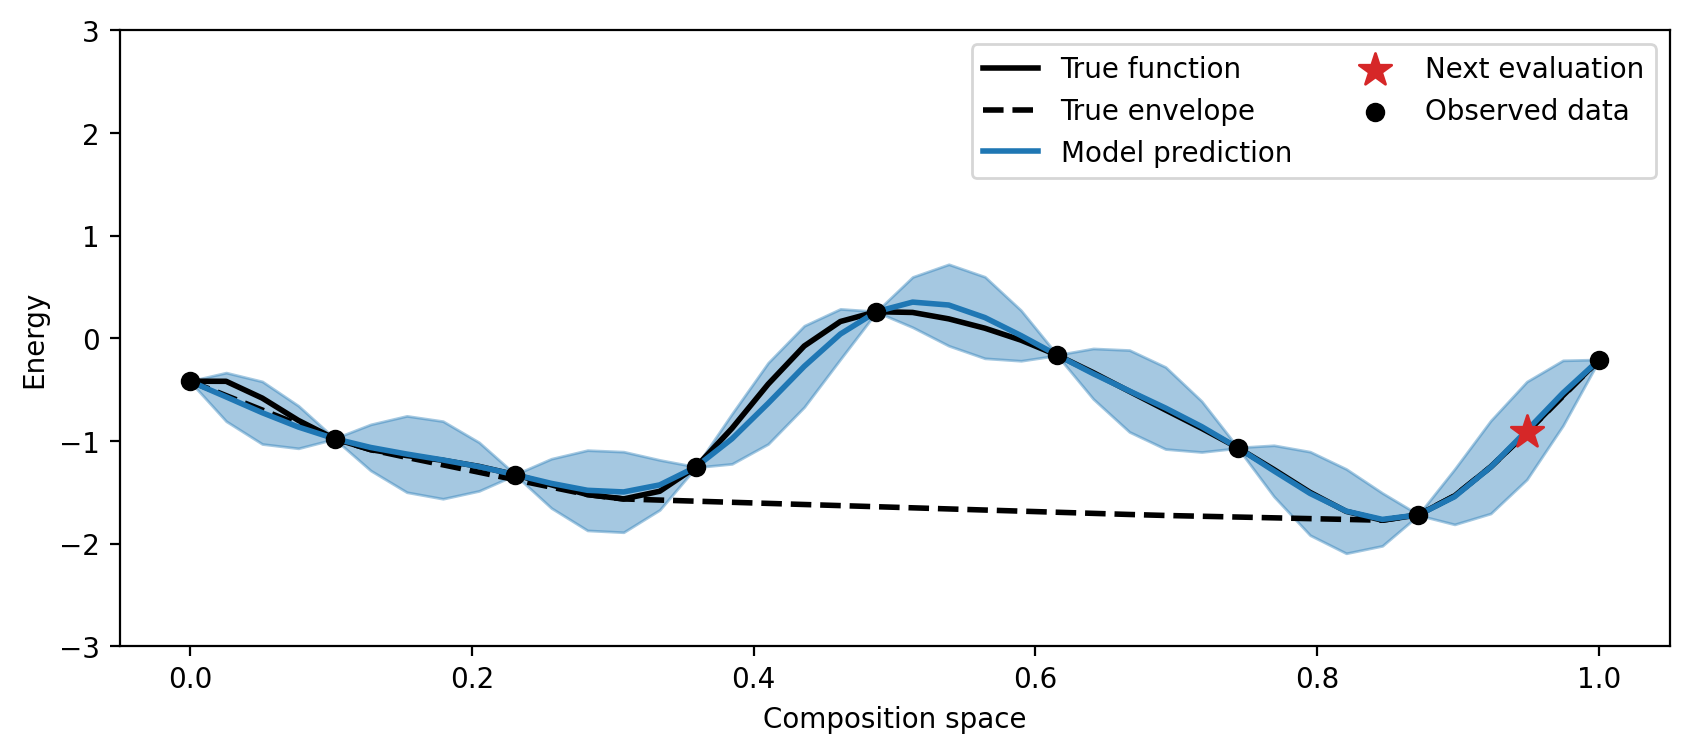

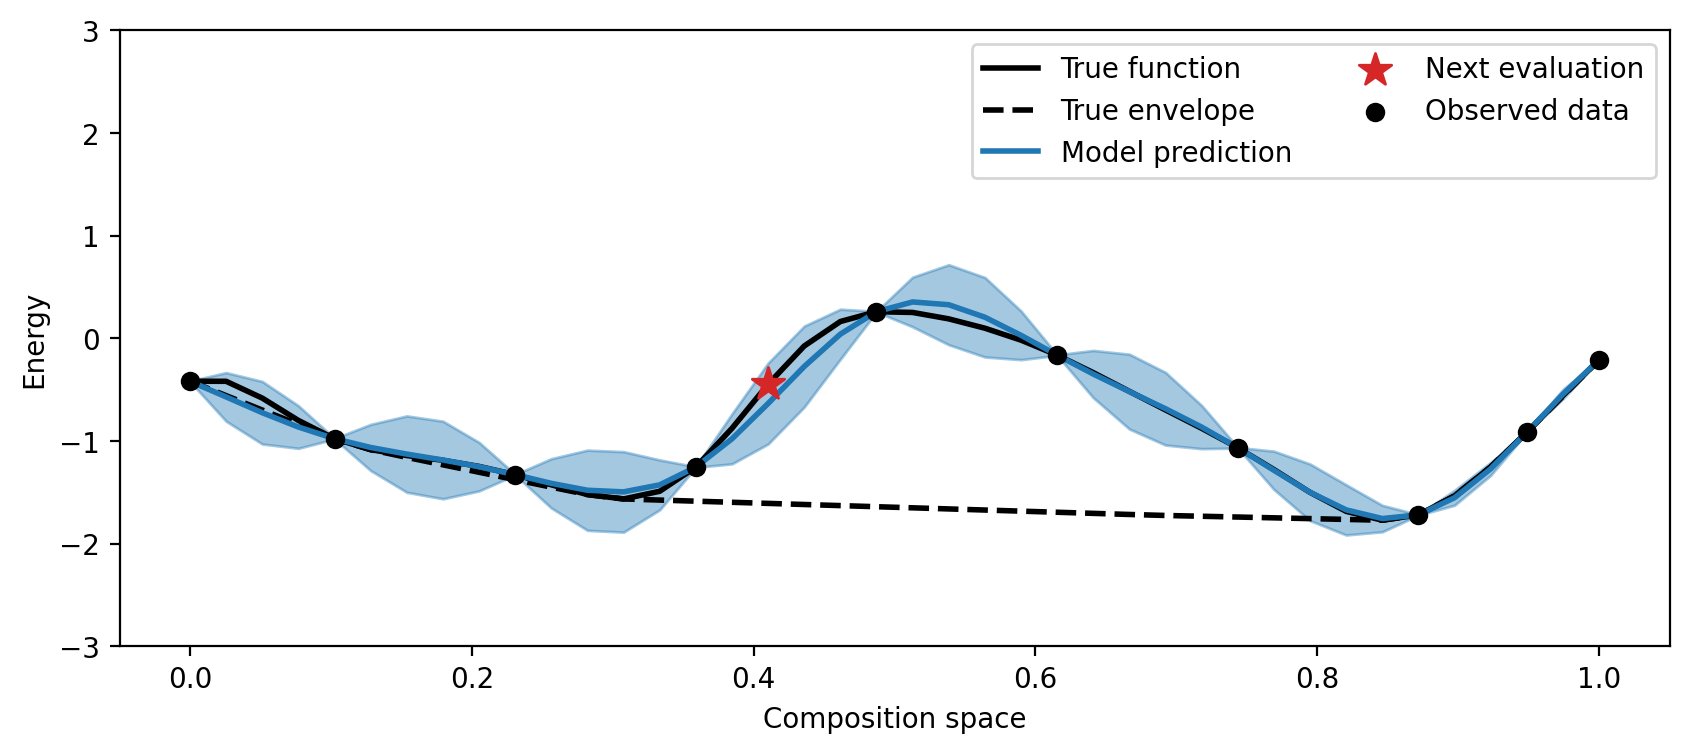

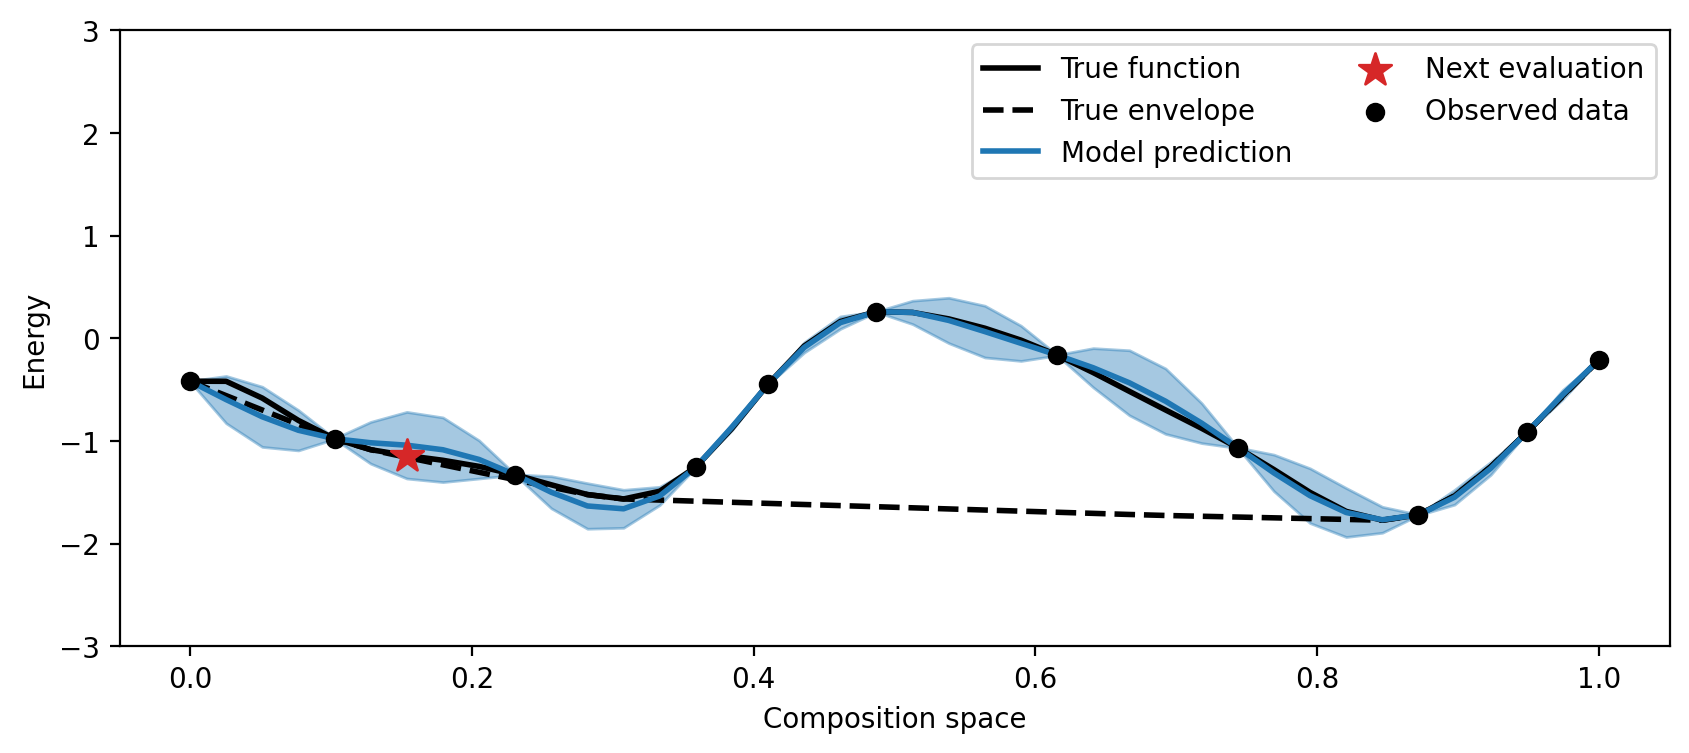

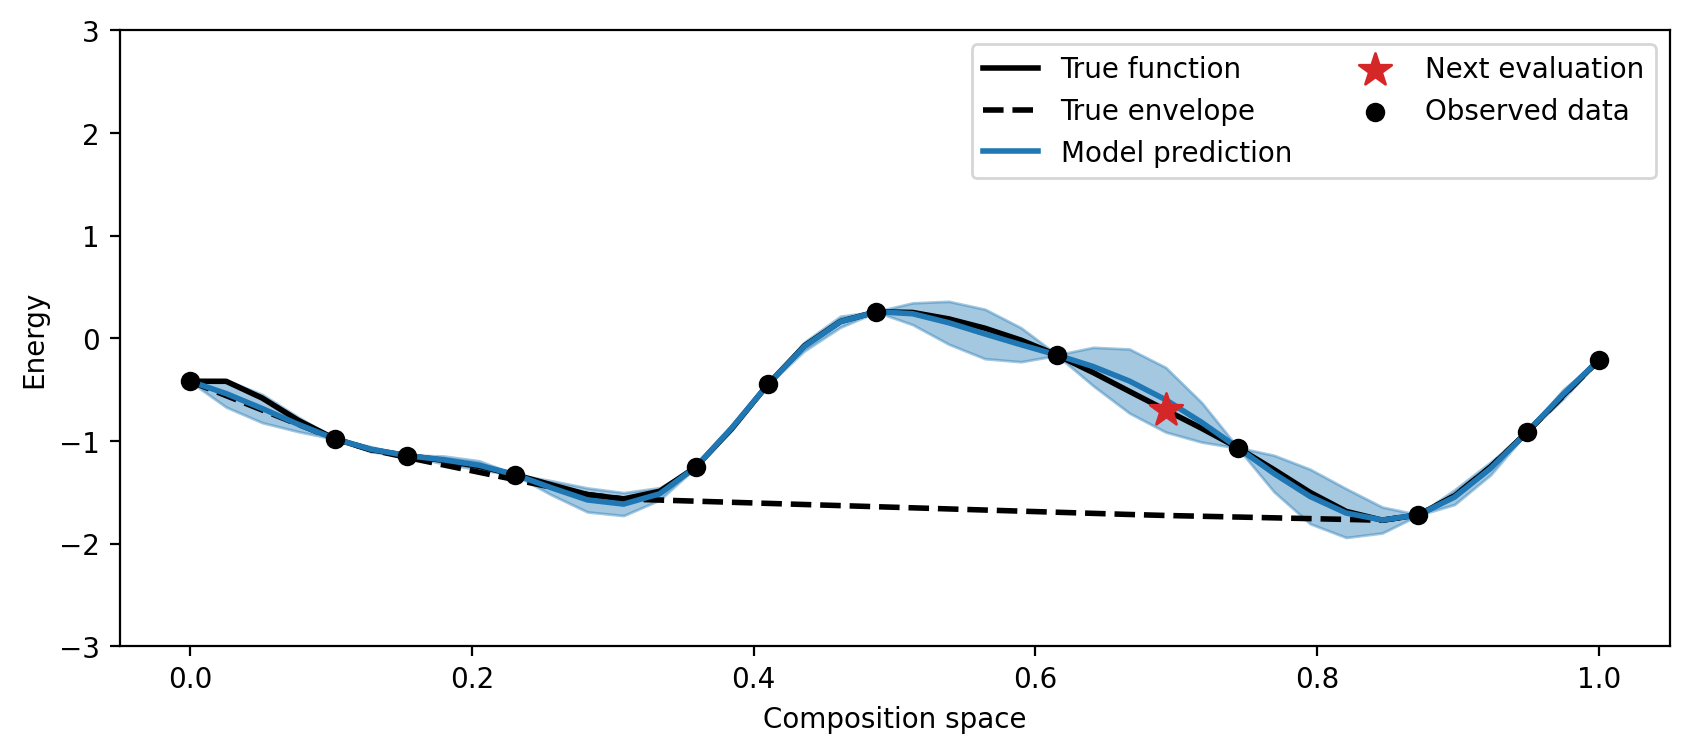

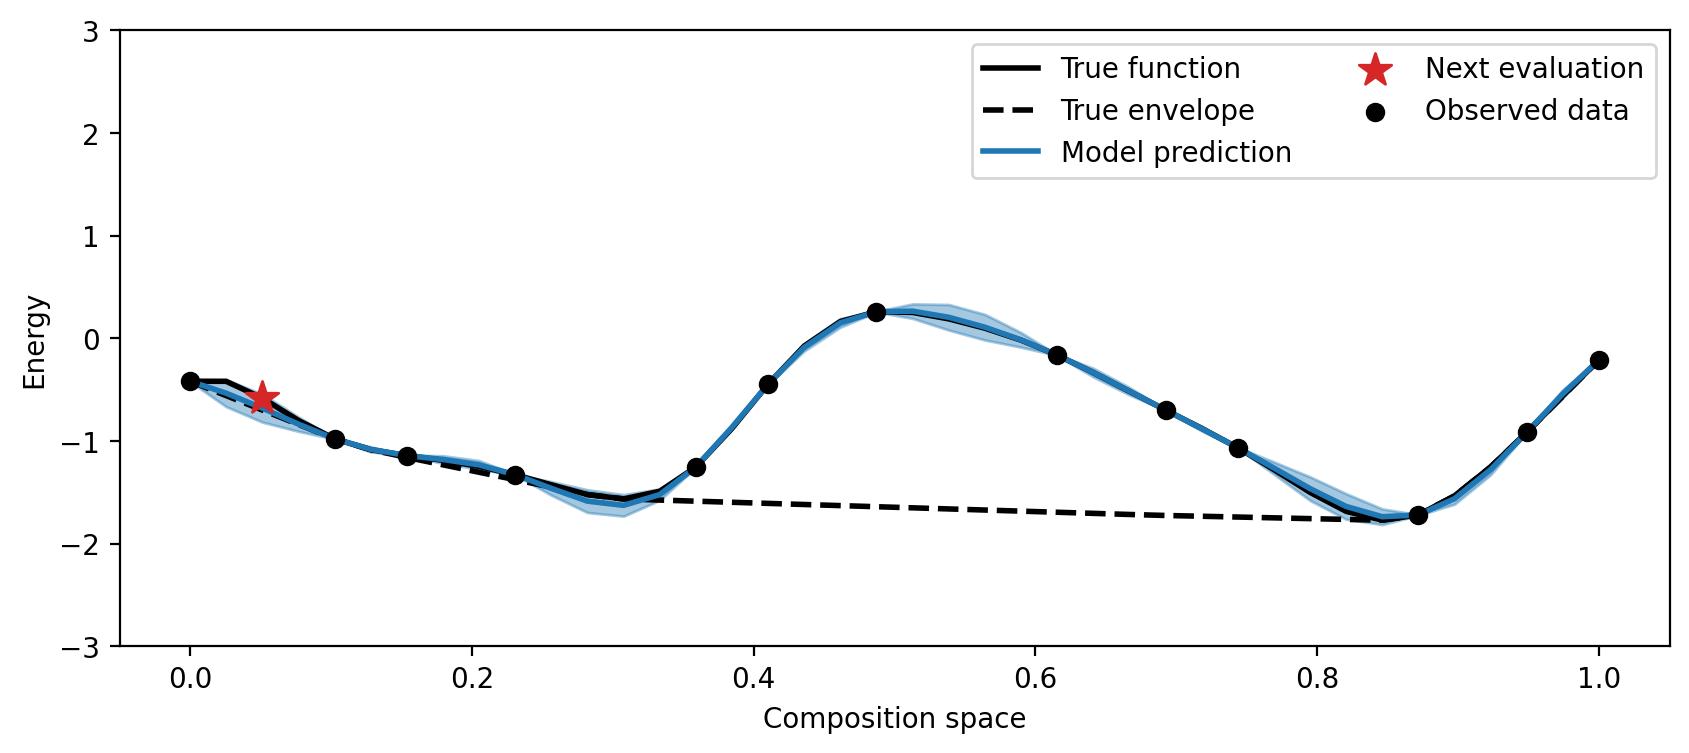

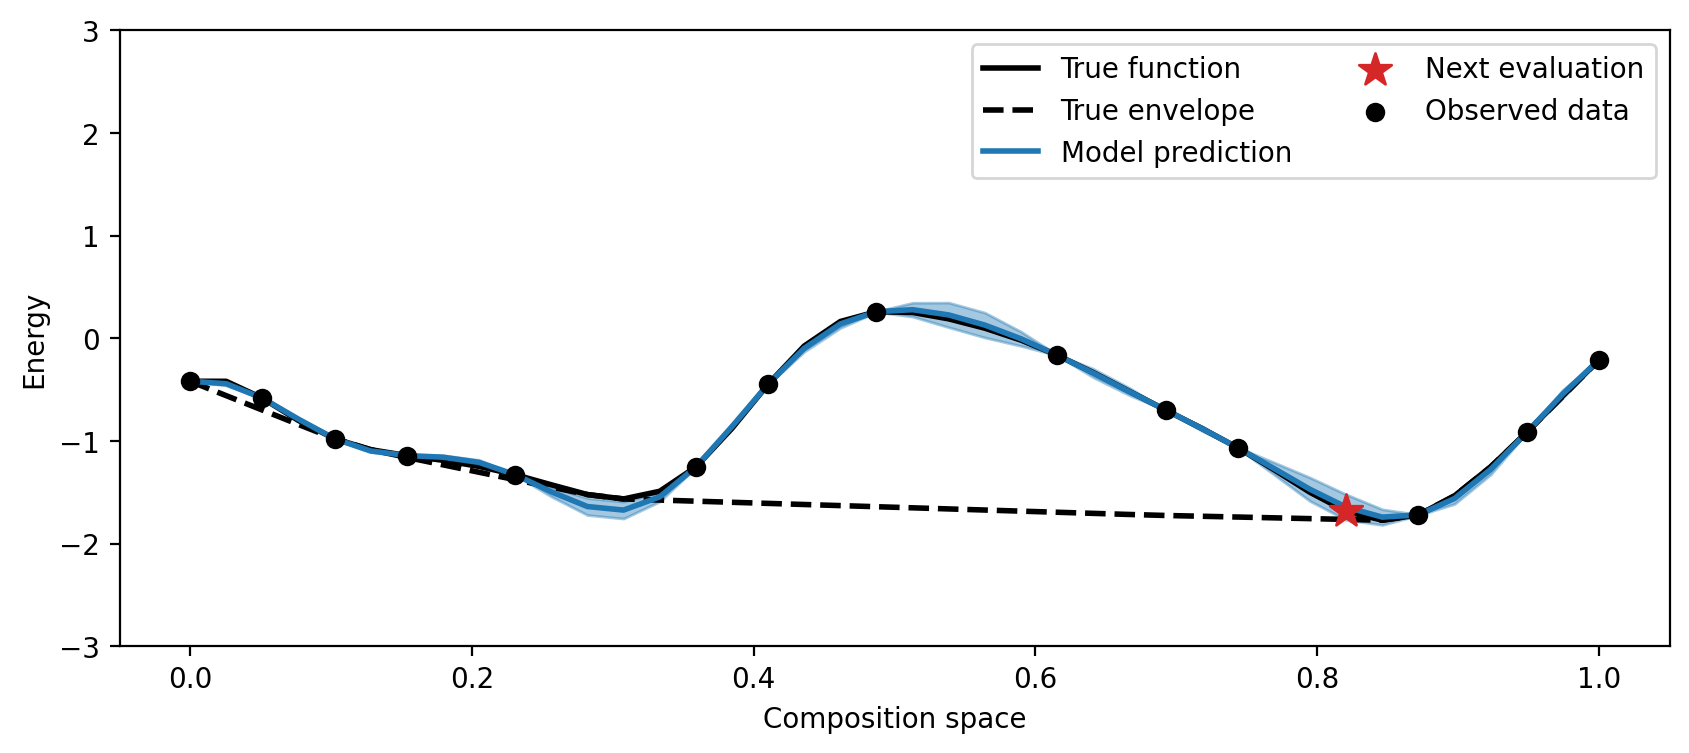

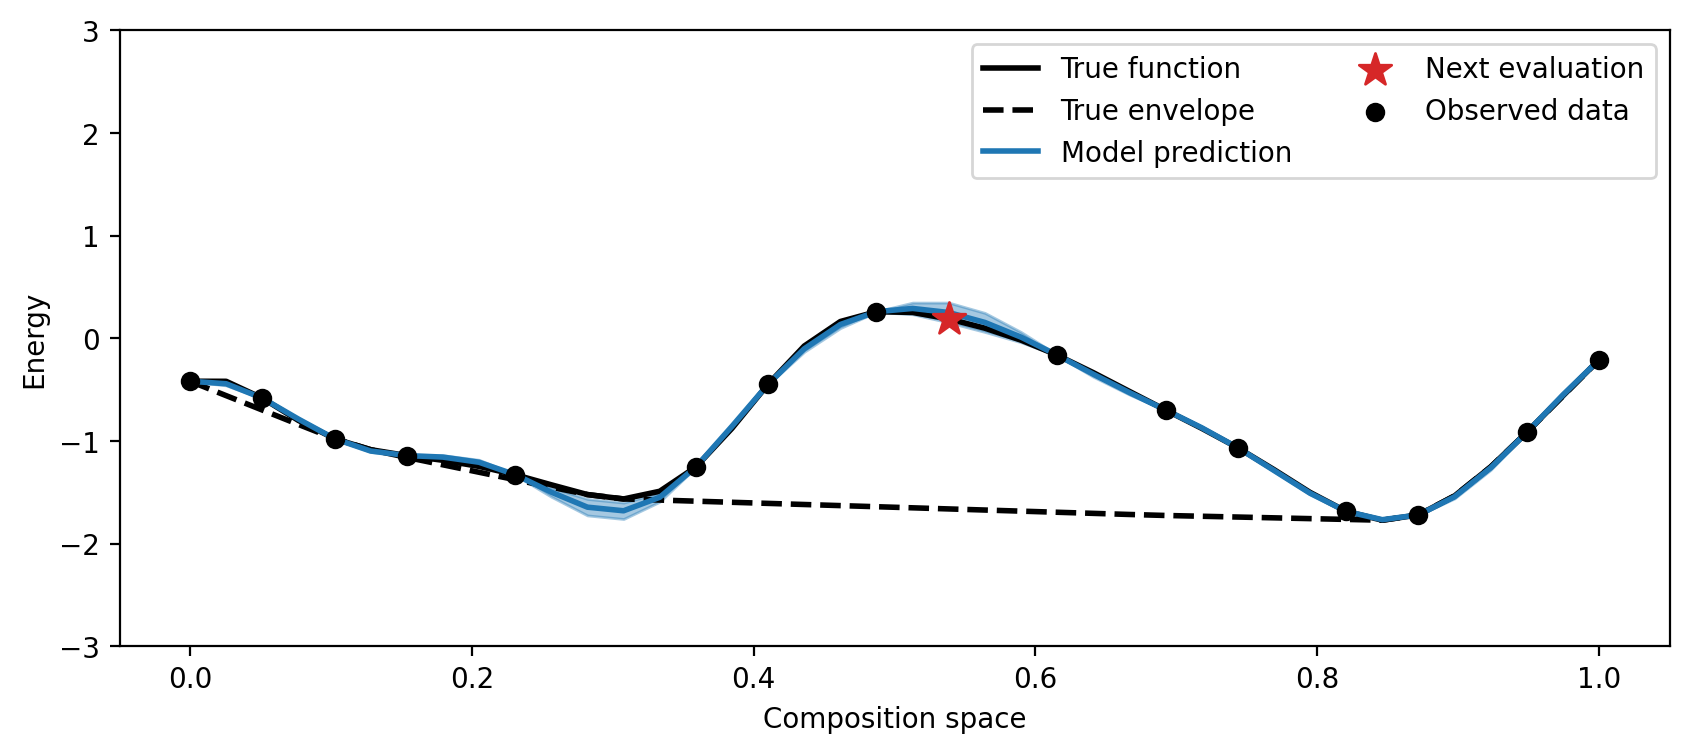

In [4]:
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# Suppose we start out by observing the two end points
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

distances_baseline = []; distances_baseline.append(compute_distances(dataset, design_space, true_envelope))

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):
    print("Iteration: ", i)

    %time next_x, entropy_change = get_next_candidate_baseline(posterior, params, dataset, designs, design_space)
    #print(entropy_change)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, [], dataset, next_x, entropy_change, plot_eig=False, plot_hulls=False)
    
    # add observations to data and update model
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)
    distances_baseline.append(compute_distances(dataset, design_space, true_envelope))

# Convex-hull-aware active search (CHAASe)

Iteration:  0
CPU times: user 3min 22s, sys: 1.7 s, total: 3min 24s
Wall time: 2min 13s
[0.8974359] [1.01423794 1.0732746  1.10494714 1.09958015 1.06556395 1.01670952
 0.97057343 0.93418402 0.9077173  0.89093155 0.88403582 0.88549811
 0.87894902 0.87241243 0.86765669 0.86132705 0.85898471 0.84376658
 0.81697726 0.79635101 0.78987654 0.79765993 0.81727366 0.83121507
 0.84025642 0.83747498 0.83077435 0.83478089 0.84186974 0.87162772
 0.9200941  0.9768866  1.05461647 1.13387764 1.16989537 1.16235253
 1.11519149 1.04929136]
Iteration:  1
CPU times: user 3min 48s, sys: 1.77 s, total: 3min 50s
Wall time: 2min 29s
[0.94871795] [1.77829662 1.81167783 1.83020358 1.83591521 1.82930691 1.80575787
 1.78116527 1.75041936 1.72847186 1.72702968 1.74193096 1.776689
 1.79953853 1.78697328 1.79074896 1.79923774 1.78935534 1.76840305
 1.74547625 1.73459045 1.74610561 1.77449244 1.78655852 1.78169898
 1.78085161 1.81686191 1.87095145 1.94917762 2.07115893 2.22833081
 2.41397582 2.55146769 2.54226102 2.241

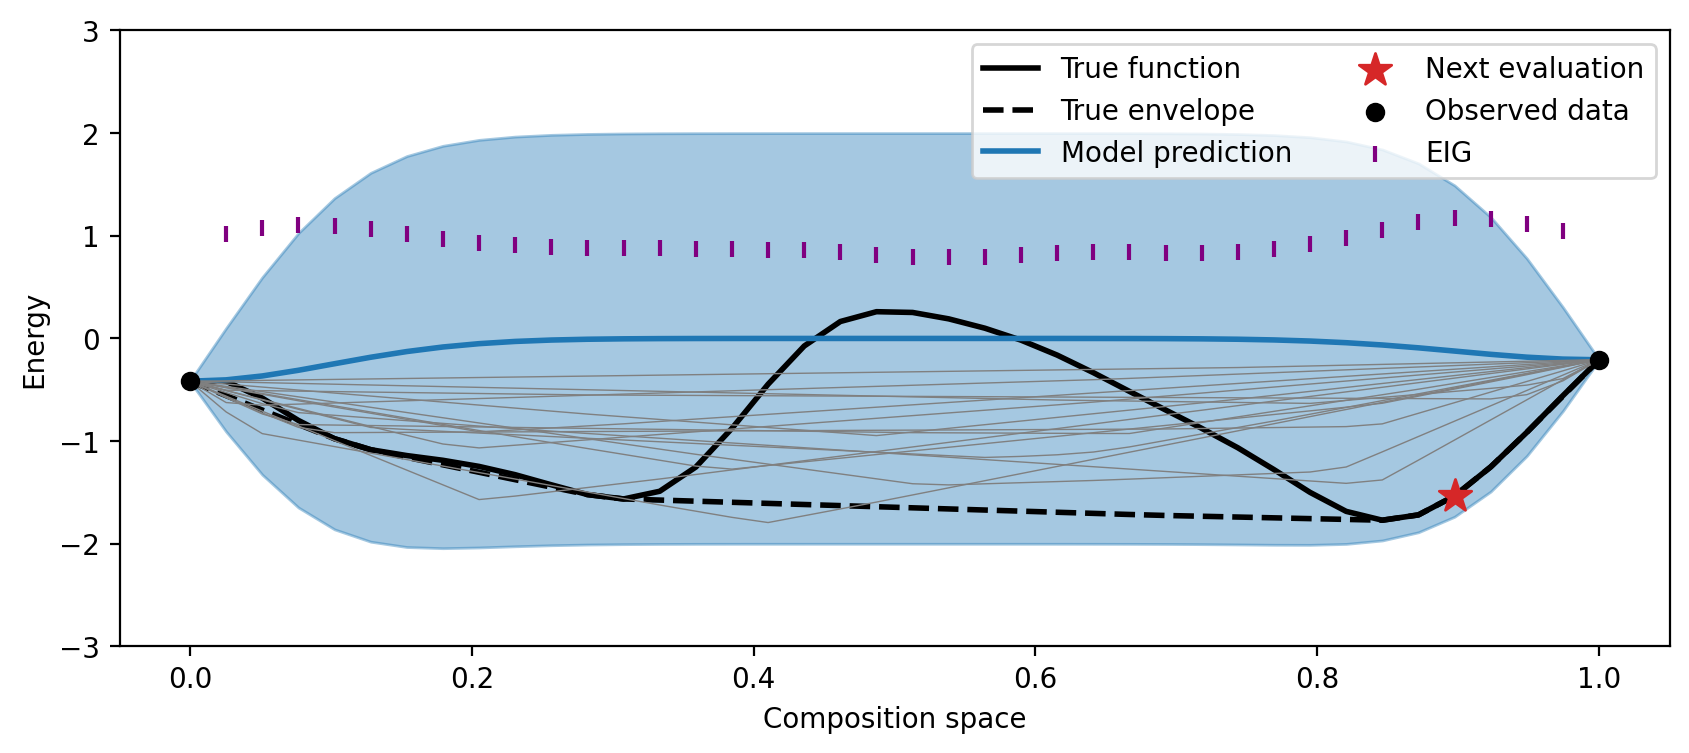

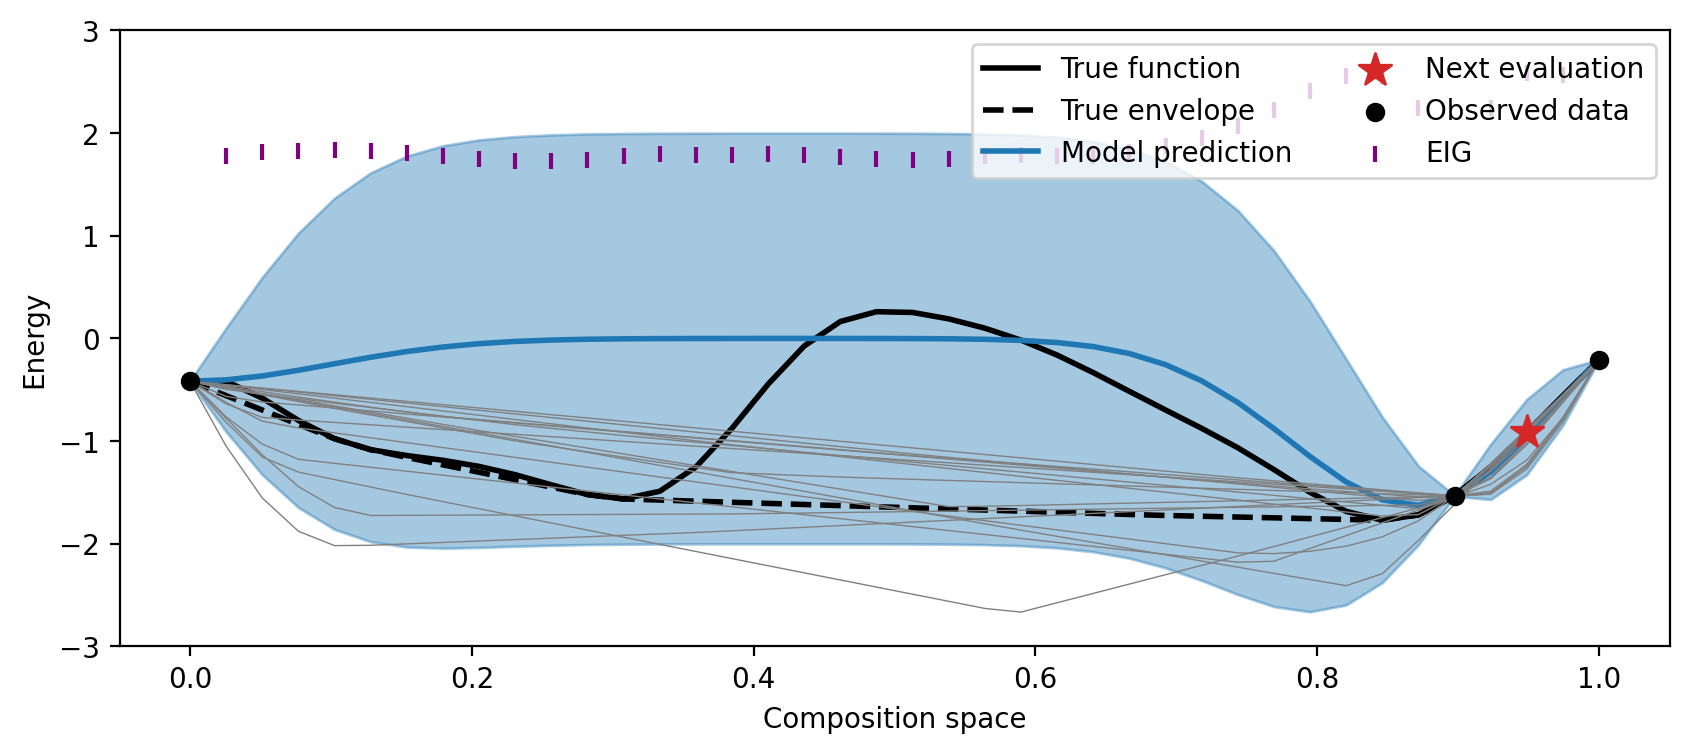

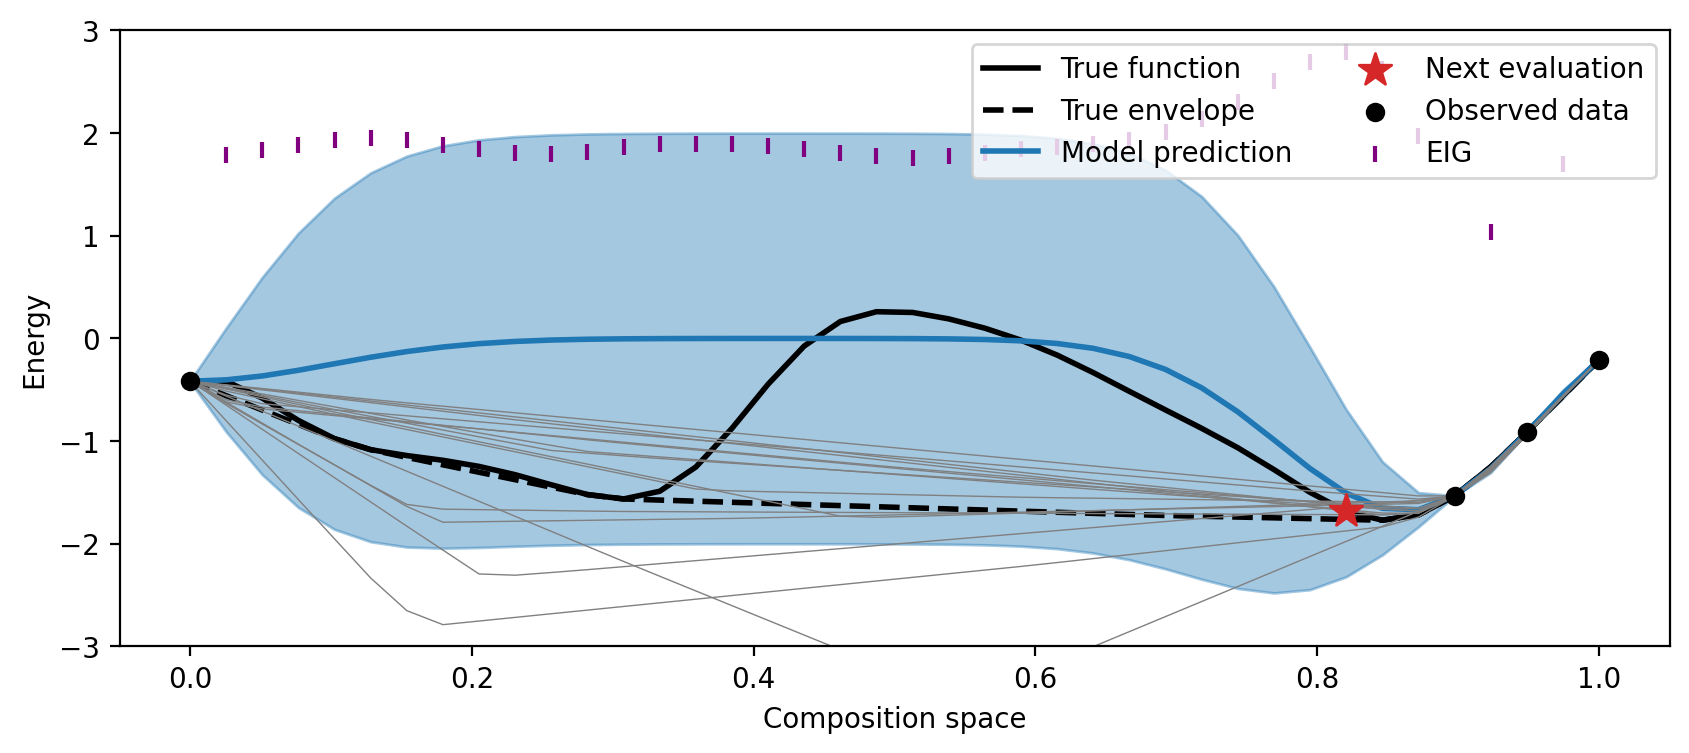

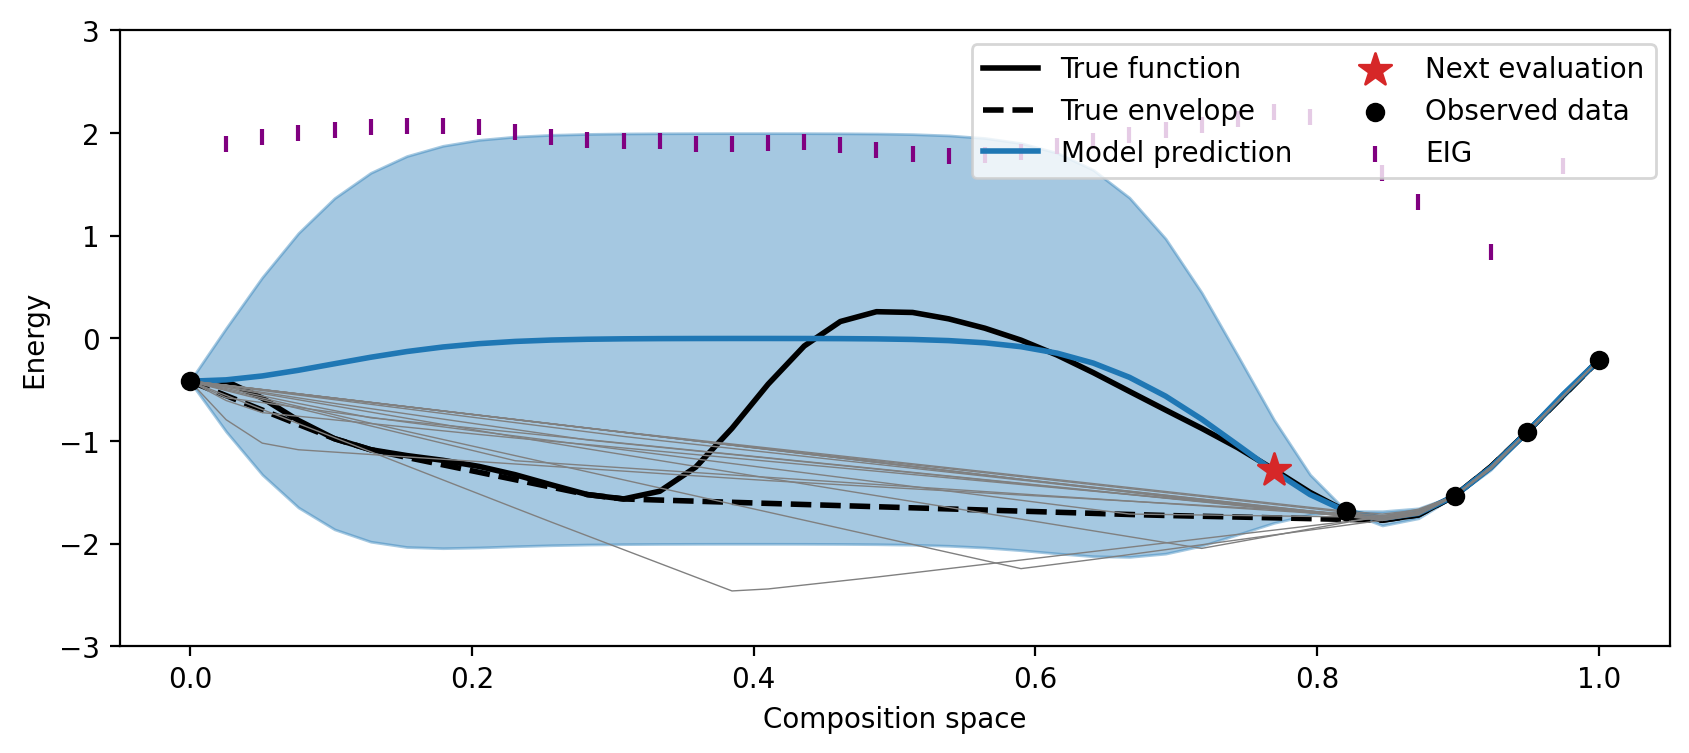

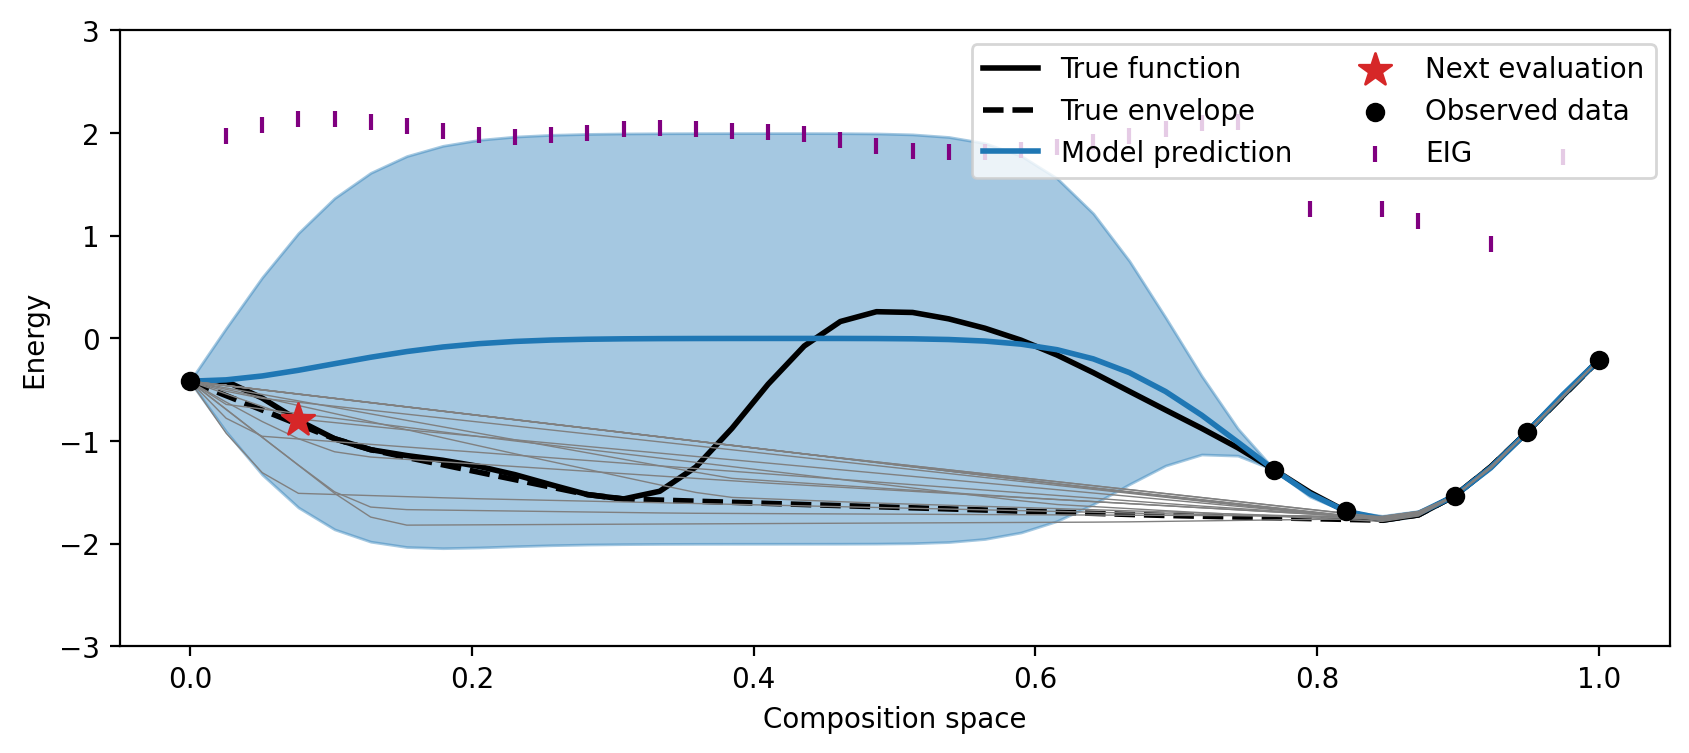

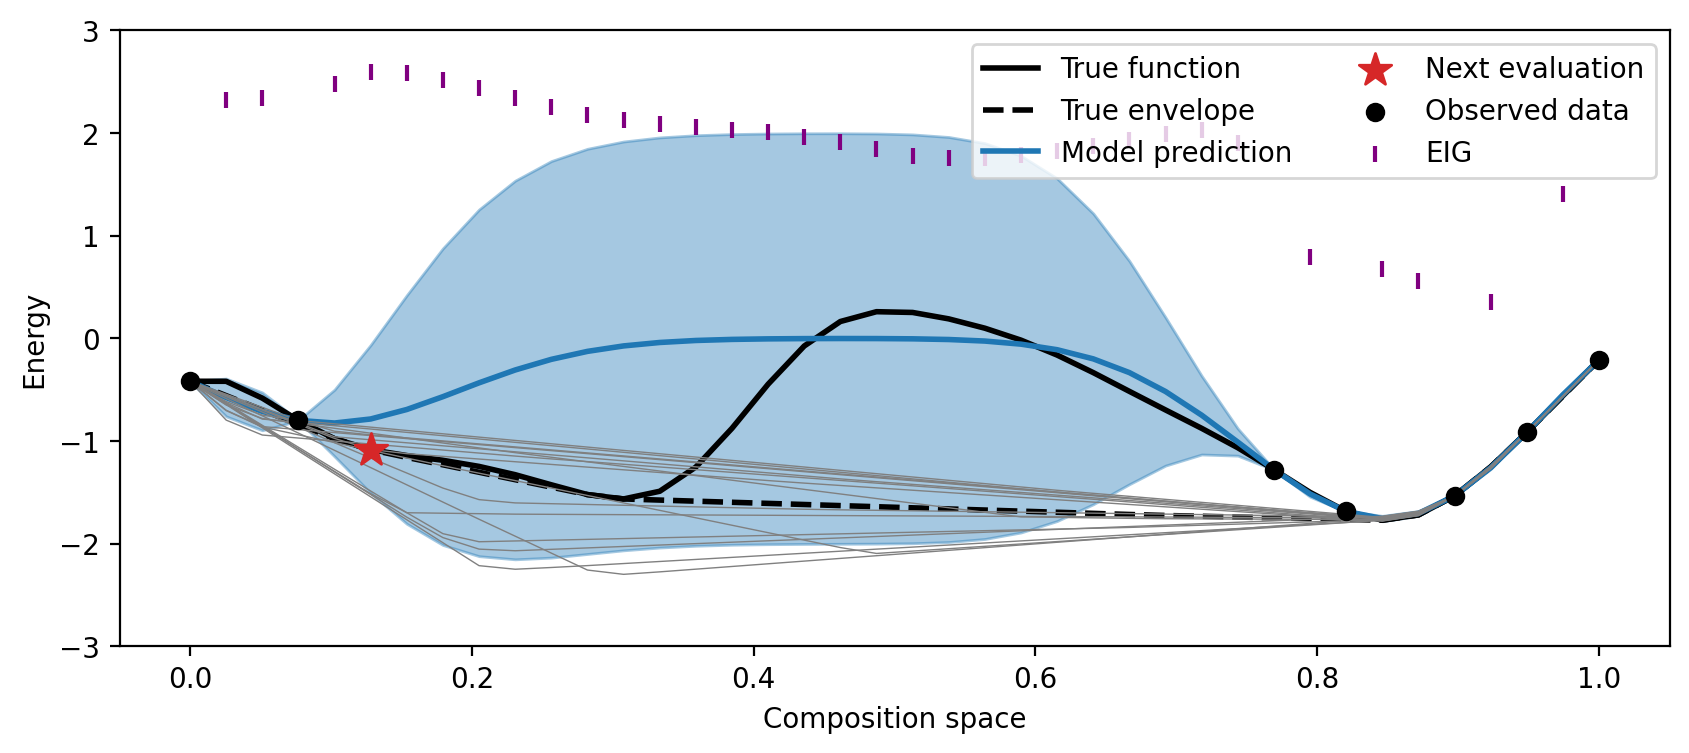

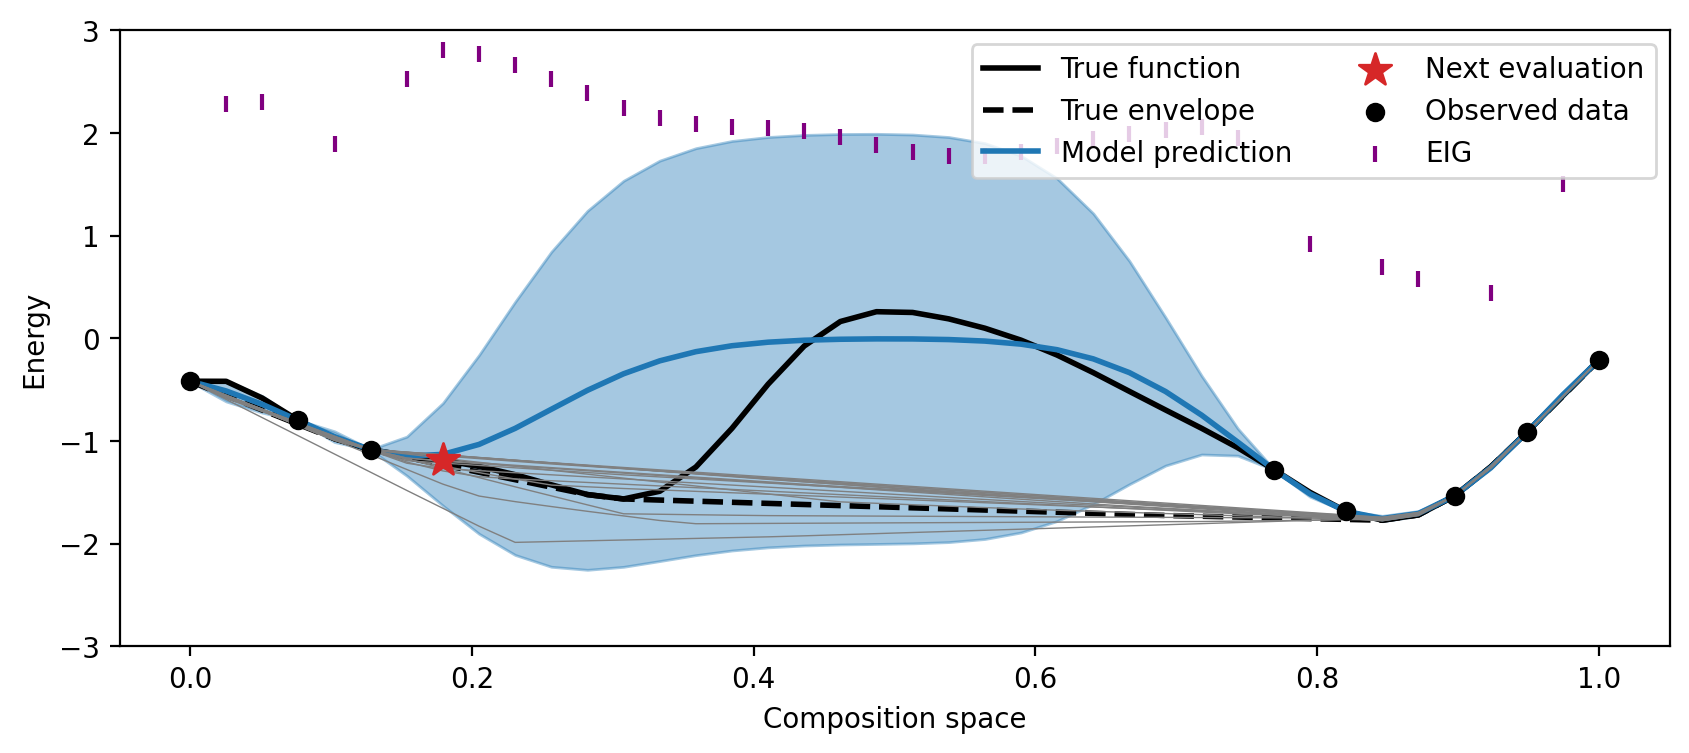

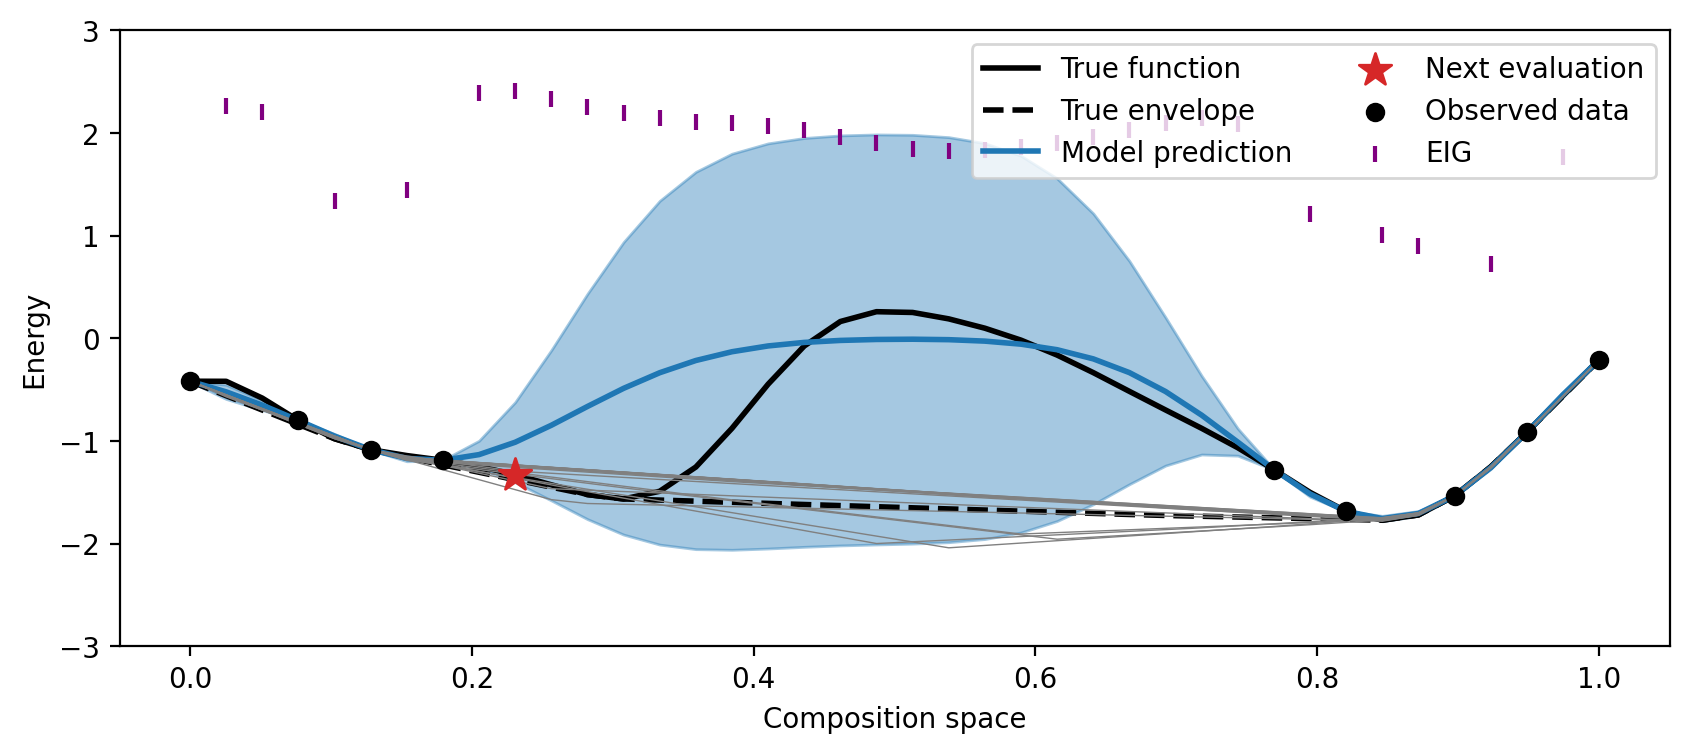

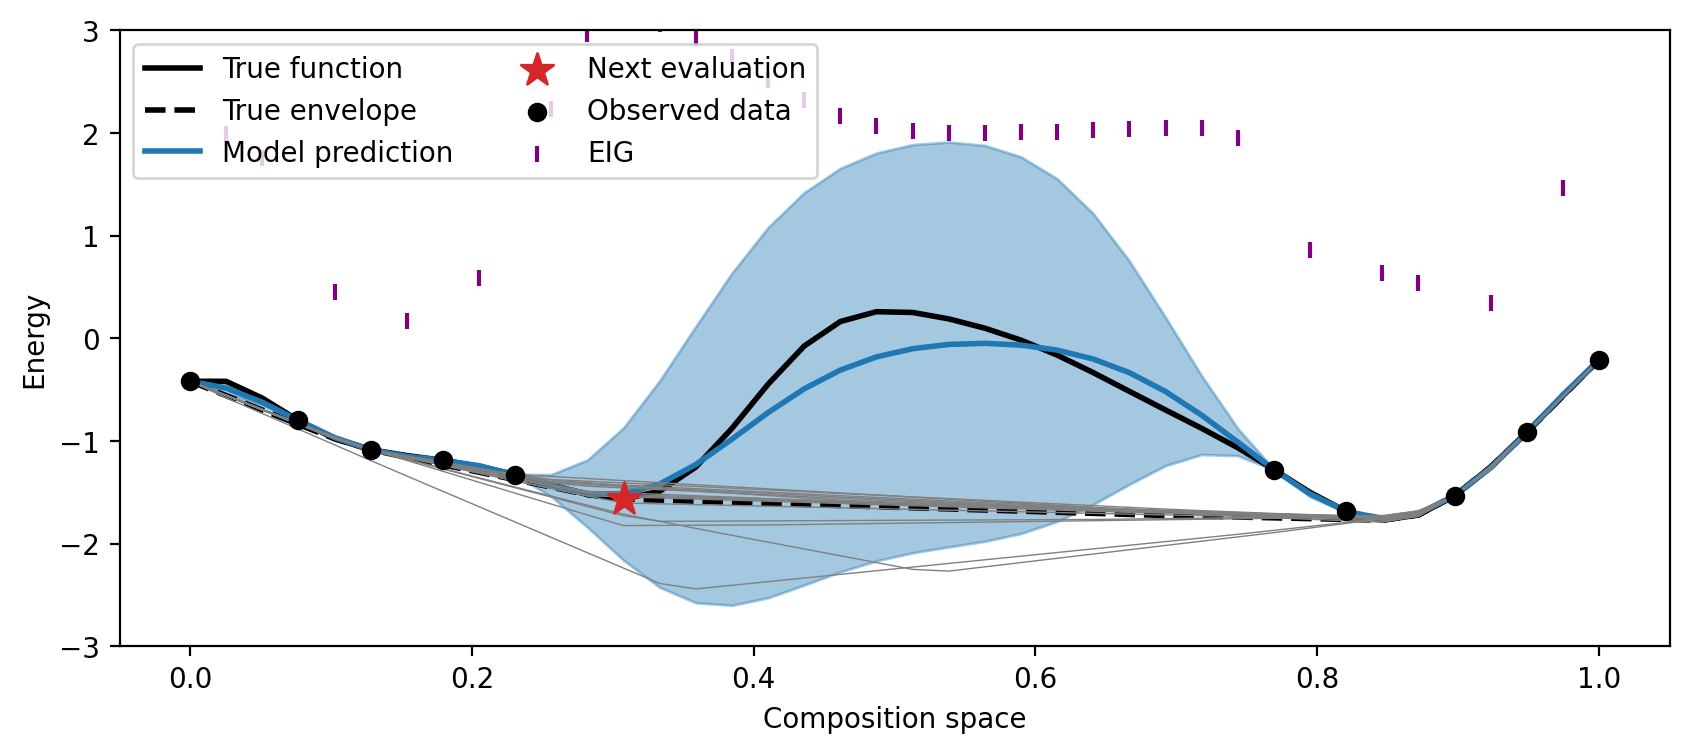

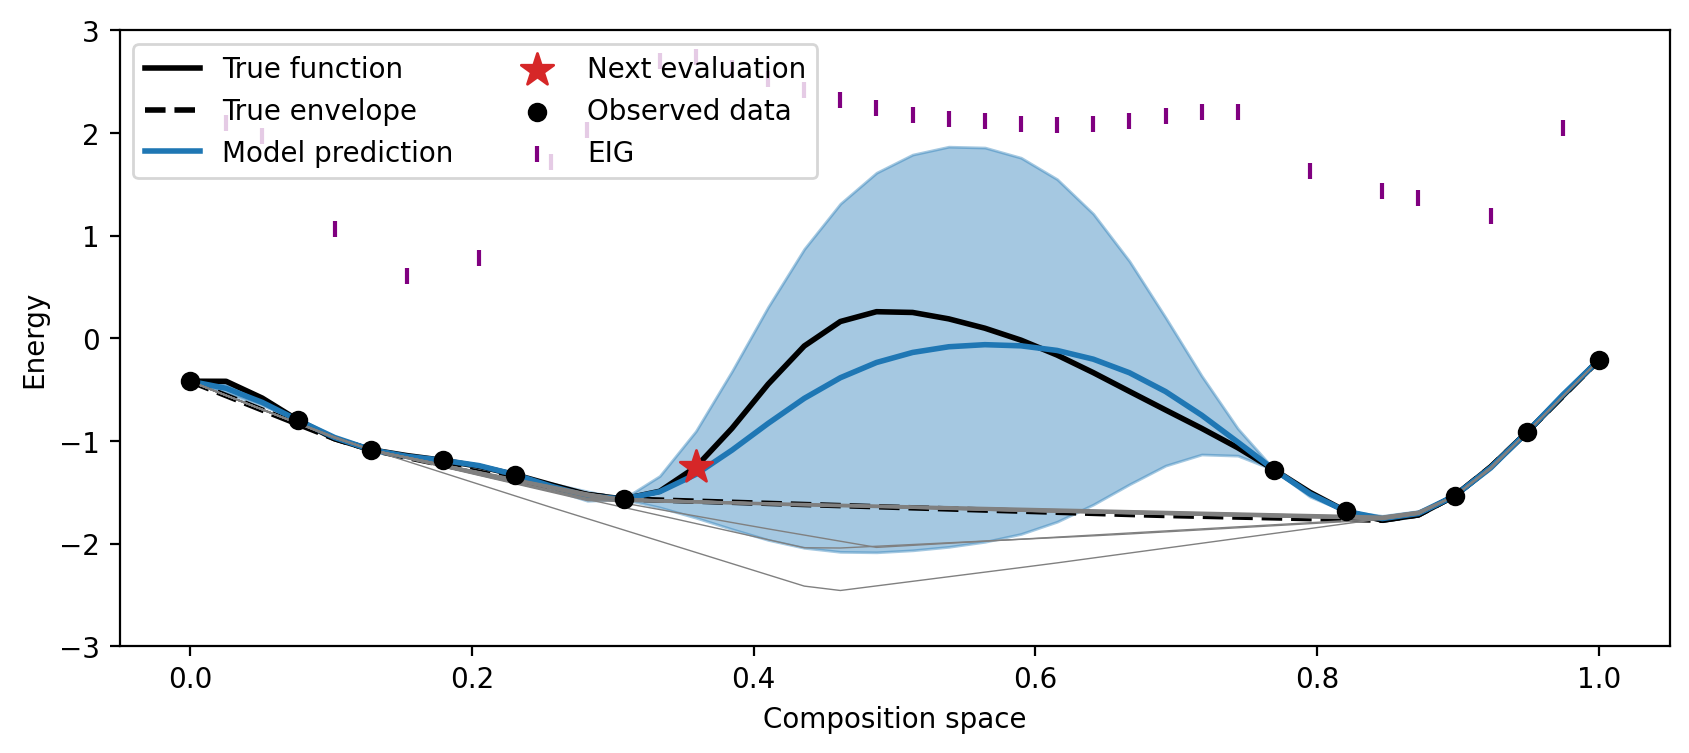

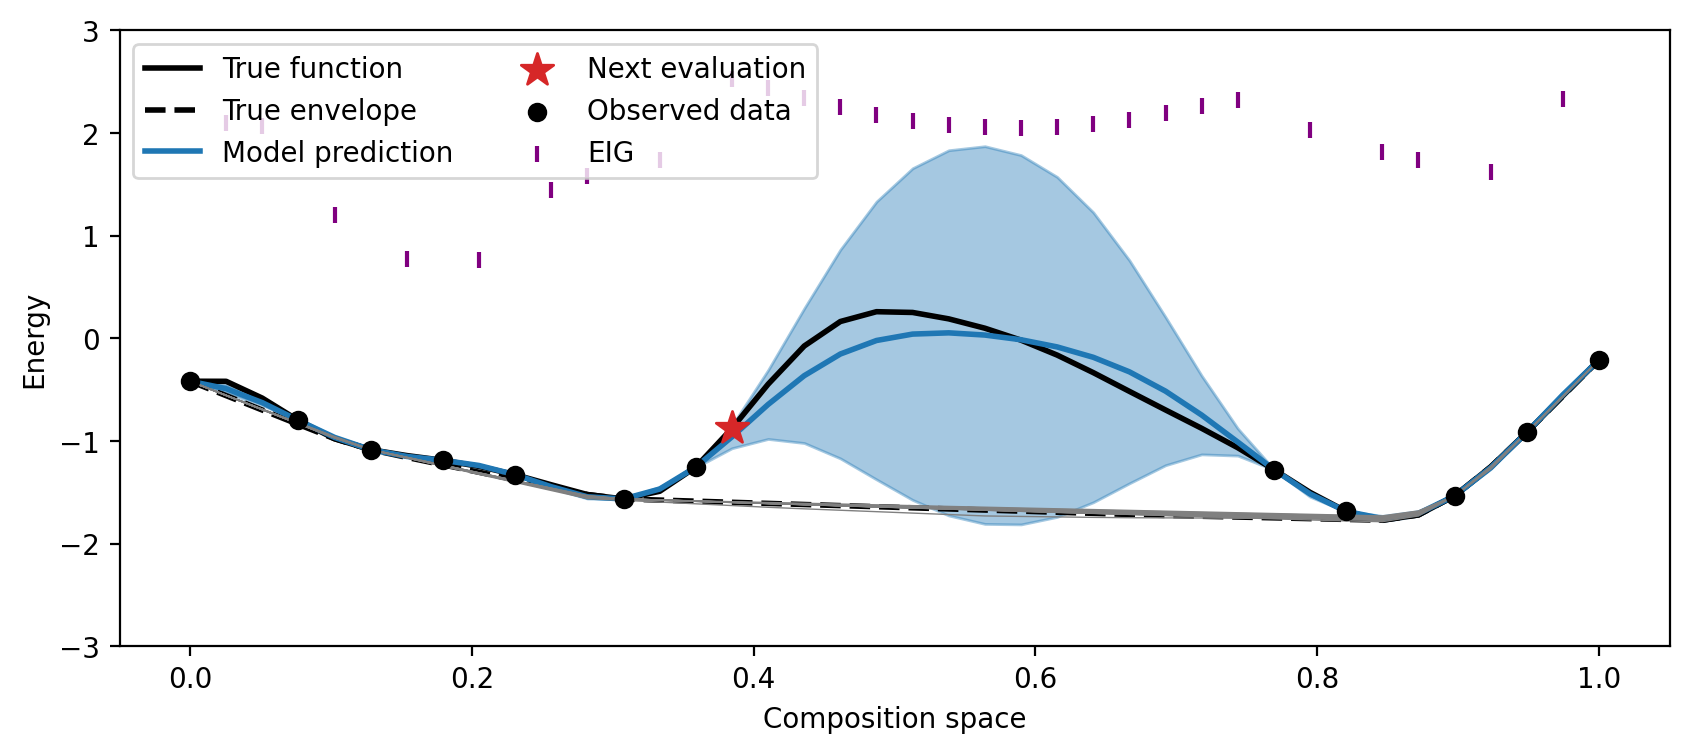

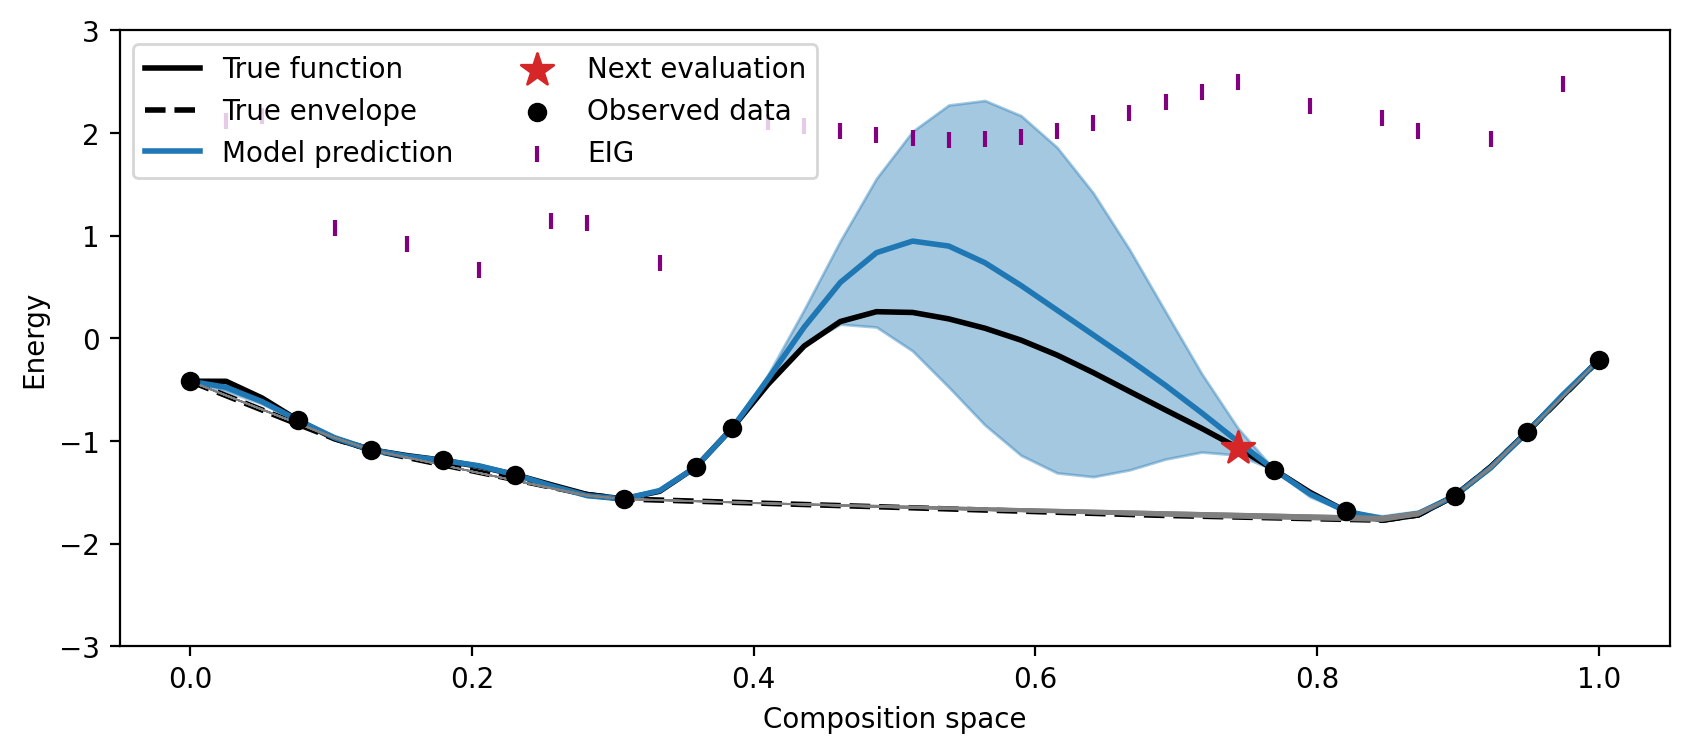

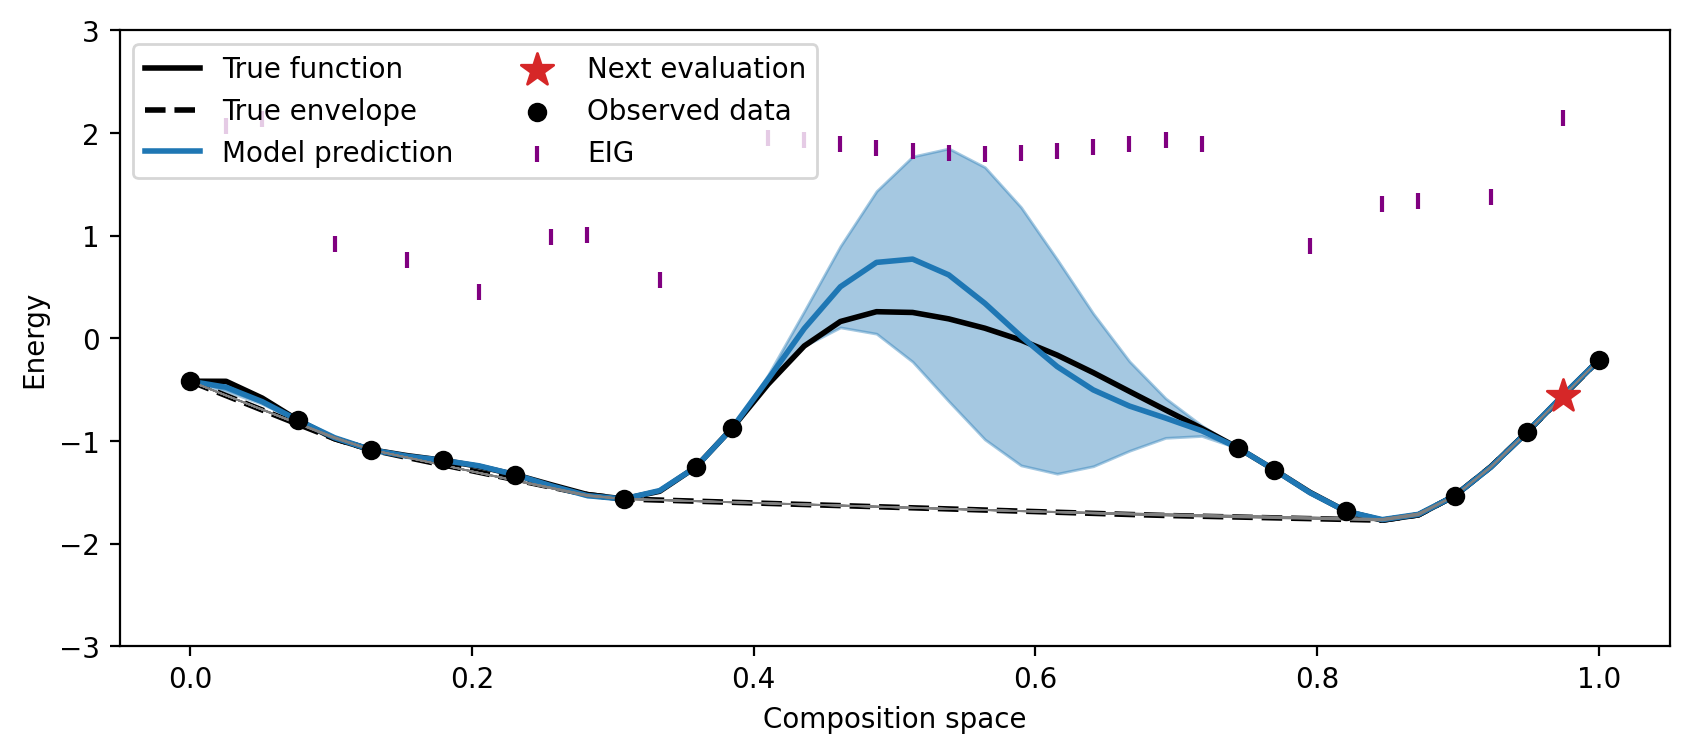

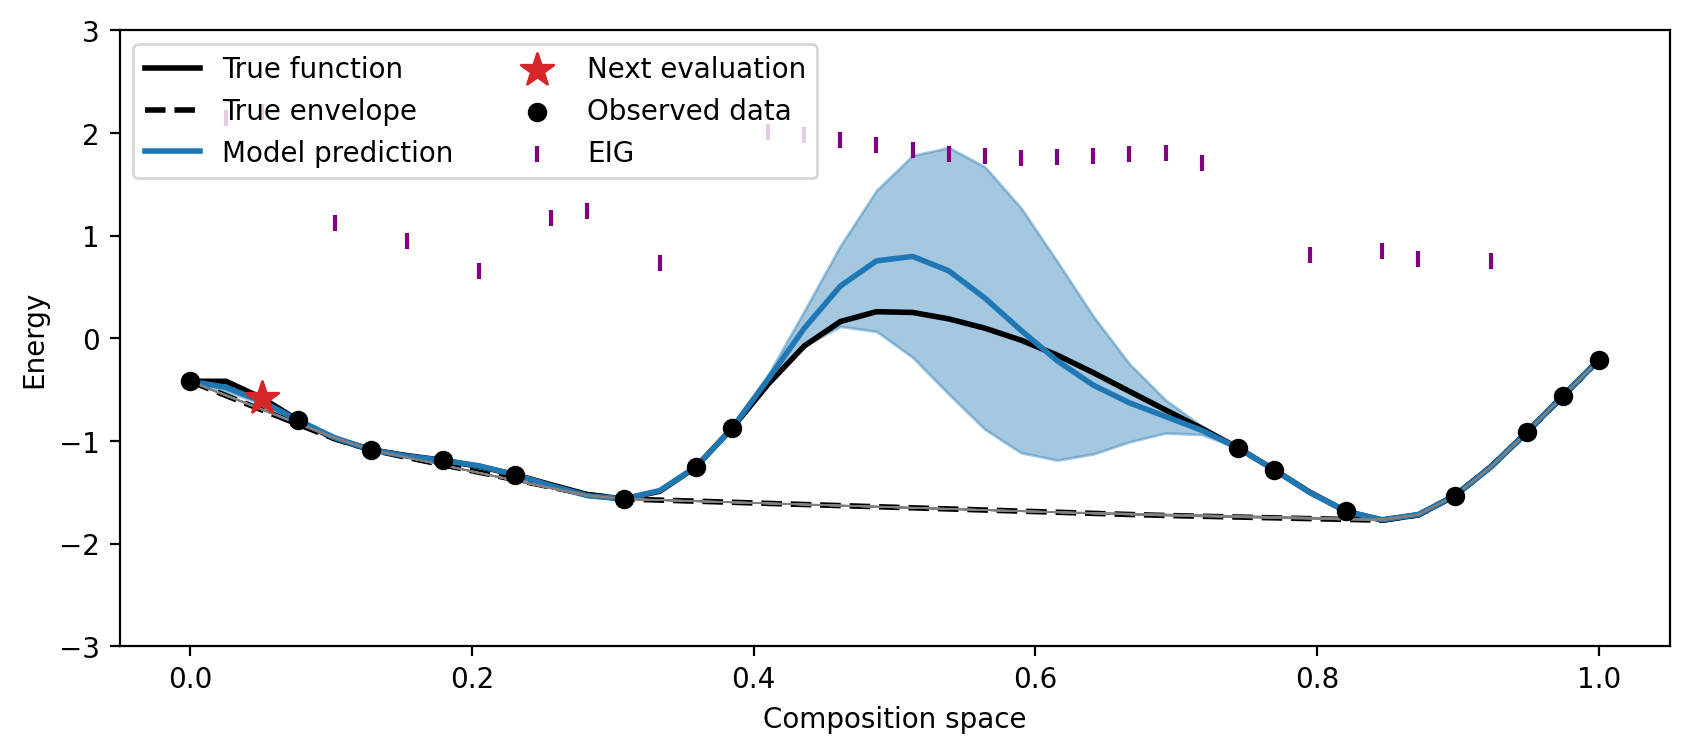

In [5]:
npr.seed(seed); rng_key = jrnd.PRNGKey(seed)

# Suppose we start out by observing the two end points
train_x = jnp.array([design_space[0], design_space[-1]]); train_y = jnp.array([true_y[0], true_y[-1]])
dataset = Dataset(X=train_x, y=train_y[:,jnp.newaxis])
designs = design_space[1:-1]

distances = []; distances.append(compute_distances(dataset, design_space, true_envelope))

# Update the model given the data above
pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)

for i in range(num_iters):
    print("Iteration: ", i)
    
    %time next_x, entropy_change = get_next_candidate(posterior, params, dataset, designs, design_space, rng_key, T=200, J=200)
    print(next_x, entropy_change)
    
    _, envelopes, _ = sample_from_posterior(pred_mean, pred_cov, design_space, 15)
    plot_candidate(knot_x, true_y, true_envelope, pred_mean, pred_cov, envelopes, dataset, next_x, entropy_change, plot_eig=True, plot_hulls=True, designs=designs)

    # add observations to data and update list of designs and update model
    dataset = dataset + Dataset(X=jnp.atleast_2d(next_x), y=jnp.atleast_2d(get_next_y(true_y, design_space, next_x)))
    designs = jnp.delete(designs, (designs == next_x).argmax())[:, jnp.newaxis]
    pred_mean, pred_cov, posterior, params = update_model(dataset, design_space, rng_key, update_params=False)
    distances.append(compute_distances(dataset, design_space, true_envelope))

# Comparison between the two methods

Here we plot the distance of each data point from the true hull by iteration. 
Regions where the plot is flat from iteration to iteration represent stable points; 
small increases represent points that are close to the hull, 
and large increases represent points that are far from the hull.

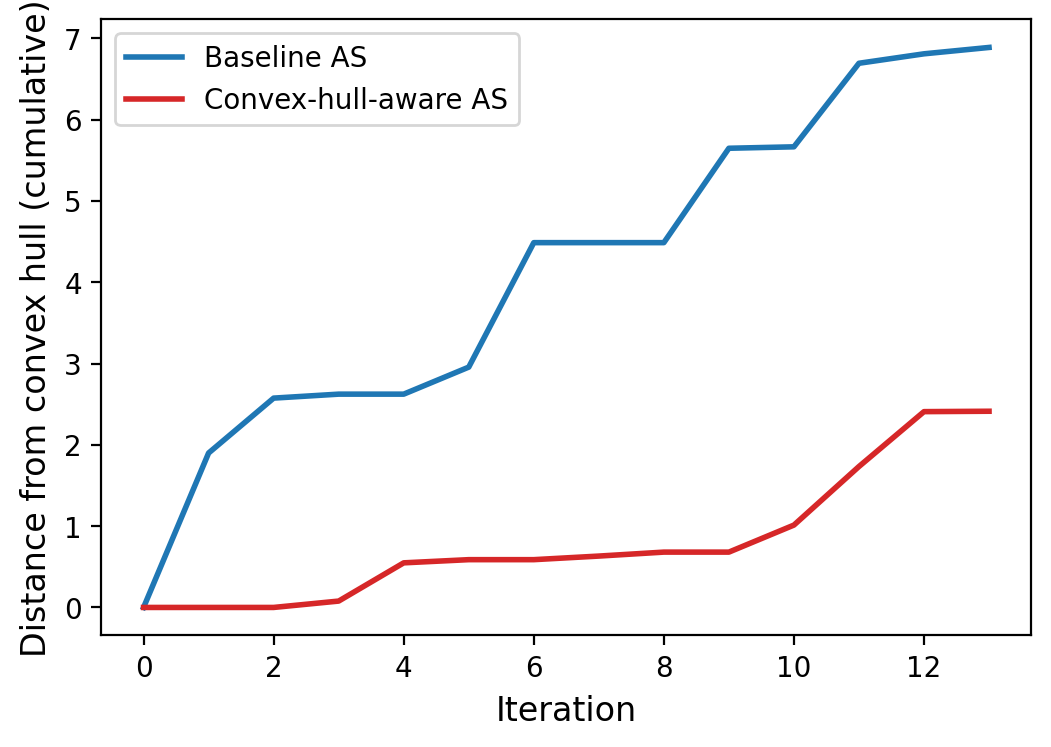

In [6]:
plt.figure(figsize=(6,4)); fs=12; niter=14
c_dist_baseline = [distance.sum() for distance in distances_baseline[0:niter]]
c_dist = [distance.sum() for distance in distances[0:niter]]
                     
plt.plot(c_dist_baseline, label="Baseline AS", lw=2, c="tab:blue")
plt.plot(c_dist, label="Convex-hull-aware AS", lw=2, c="tab:red")

plt.xlabel("Iteration", fontsize=fs); plt.ylabel("Distance from convex hull (cumulative)", fontsize=fs)
plt.legend()
#plt.xlim(-0.9, 12)

In [7]:
n_stable = 2; tol = 1e-2
stables_baseline = [n_stable]
for i in range(len(c_dist_baseline)-1):
    if (c_dist_baseline[i+1] - c_dist_baseline[i]) <= tol:
        n_stable += 1
    stables_baseline.append(n_stable)
    
n_stable = 2
stables = [n_stable]
for i in range(len(c_dist)-1):
    if (c_dist[i+1] - c_dist[i]) <= tol:
        n_stable += 1
    stables.append(n_stable)

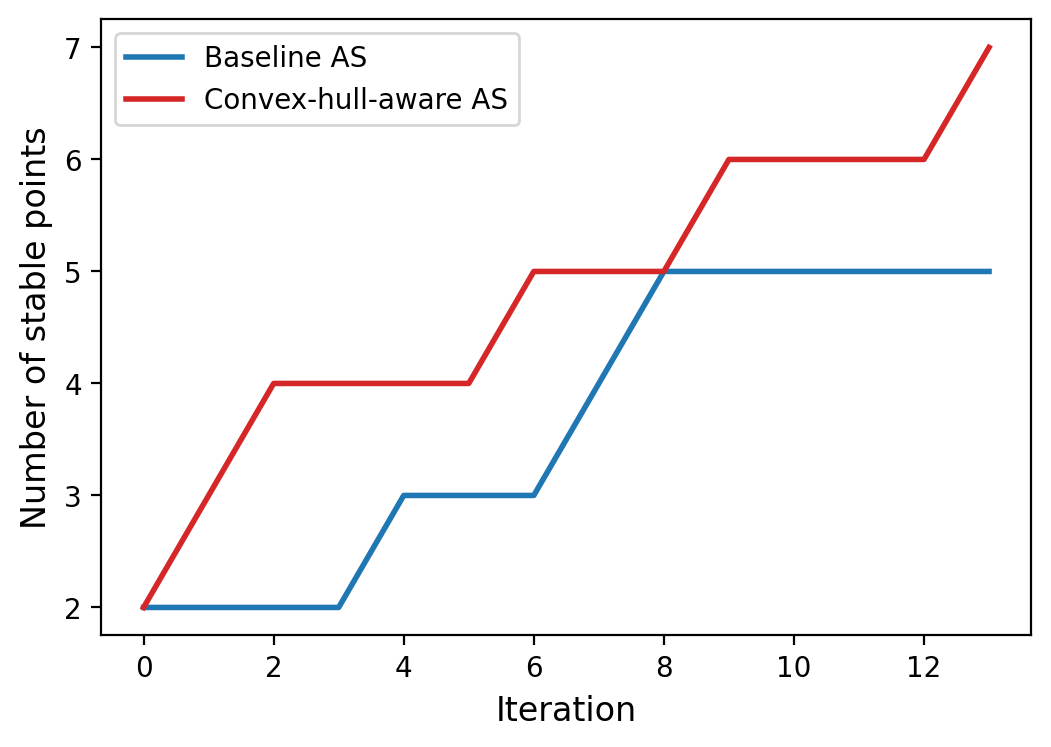

In [8]:
plt.figure(figsize=(6,4)); fs=12
                     
plt.plot(stables_baseline, label="Baseline AS", lw=2, c="tab:blue")
plt.plot(stables, label="Convex-hull-aware AS", lw=2, c="tab:red")

plt.xlabel("Iteration", fontsize=fs); plt.ylabel("Number of stable points", fontsize=fs)
plt.legend()